(eda2)=
# EDA Part 2: Case Analysis

In this section, we will be analyzing the cases ({numref}`eda1_case_dataset`): calcification and mass datasets containing patient, abnormality, BI-RADS assessment, image image_view, breast density, subtlety, and pathology (diagnosis) information. We aim to obtain insight into the CBIS-DATASET, specifically regarding factors that distinguish benign from malignant diagnoses in digital mammography screening.

```{table} Case Dataset Dictionary
:name: eda1_case_dataset
| Variable          | Section | Definition                                                              |
|-------------------|---------|-------------------------------------------------------------------------|
| breast_density    | Case    | BI-RADS categorization of the amount of fibroglandular tissue (FGT)     |
| laterality        | Case    | Left or right breast                                                    |
| image_view        | Case    | Craniocaudal (CC) or Mediolateral Oblique (MLO) view                    |
| abnormality_id    | Case    | The number of abnormality in the mammogram.                             |
| abnormality_type  | Case    | Either calcification or mass                                            |
| calc_type         | Case    | Calcification type (when applicable)                                    |
| calc_distribution | Case    | Calcification distribution (when applicable)                            |
| assessment        | Case    | BI-RADS assessment in [0,5]                                             |
| pathology         | Case    | Either 'BENIGN, 'BENIGN_WITHOUT_CALLBACK', or 'MALIGNANT'               |
| subtlety          | Case    | Indication of reading difficulty from 0 - highly subtle to 5 - obvious. |
| mass_shape        | Case    | Shape of the mass such as round, oval, lobular, or irregular            |
| mass_margins      | Case    | The feature that separates the mass from adjacent breast parenchyma.    |
| cancer            | Case    | Either True (Malignant) or False (Benign)                               |
```

## Guiding Questions
```{tip}
“Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question, which can always be made precise.” — John Tukey
```

Here, we put forward a set of questions to motivate and guide the discovery process.

1. What are the relationships between calcification and mass morphological features and malignancy?
2. To what degree do breast density, image view, left or right side, and subtlety relate to abnormality types and malignancy?
3. What are the relative features of importance concerning diagnosis?


## Exploratory Data Analysis Plan

The EDA will be conducted in three primary stages:

1. **Univariate**: Examination of the variables independently
2. **Bivariate**: Evaluate the relations among the features and between the features and the target.
3. **Multivariate**: Discover feature importance w.r.t. screening and diagnosis.

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from scipy import stats
import pickle
import numpy as np
import matplotlib.pyplot as plt
from myst_nb import glue
import seaborn as sns
import seaborn.objects as so
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from bcd.explore.meta.case import CaseExplorer
from bcd.explore.meta.multivariate.pipeline import PipelineBuilder
from bcd.explore.meta.multivariate.selection import ModelSelector

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

Let's instantiate the Case explorer.

In [3]:
CBIS_FP = "data/meta/4_cooked/cbis.csv"
cases = CaseExplorer(cbis_filepath=CBIS_FP)
calc = CaseExplorer(cbis=cases.get_calc_data())
mass = CaseExplorer(cbis=cases.get_mass_data())

## Univariate Analysis
Let's get an overall sense of the data.

In [4]:
summary = cases.summary
glue("eda1_summary", summary)

,Summary
Patients,1566
Cases,3103
Calcification Cases,1872
Calcification Cases - Benign,1199
Calcification Cases - Malignant,673
Mass Cases,1696
Mass Cases - Benign,912
Mass Cases - Malignant,784


```{glue:figure} eda1_summary
---
align: center
name: eda1_summary_df
---
CBIS-DDSM Dataset Summary
```

In [5]:
st = summary.T
pct_calc = round(st['Calcification Cases'] / st['Cases'] * 100,2).values[0]
pct_mass = round(st['Mass Cases'] / st['Cases'] * 100,2).values[0]
pct_calc_mal = round(st['Calcification Cases - Malignant'] / st['Calcification Cases'] * 100,2).values[0]
pct_calc_bn = round(st['Calcification Cases - Benign'] / st['Calcification Cases'] * 100,2).values[0]
pct_mass_mal = round(st['Mass Cases - Malignant'] / st['Mass Cases'] * 100,2).values[0]
pct_mass_bn = round(st['Mass Cases - Benign'] / st['Mass Cases'] * 100,2).values[0]
cases_per_patient = round(st['Cases'] / st['Patients'],2).values[0]

glue("pct_calc", pct_calc)
glue("pct_mass", pct_mass)
glue("pct_calc_mal", pct_calc_mal)
glue("pct_calc_bn", pct_calc_bn)
glue("pct_mass_mal", pct_mass_mal)
glue("pct_mass_bn", pct_mass_bn)
glue("cases_per_patient", cases_per_patient)

60.33

54.66

35.95

64.05

46.23

53.77

1.98

From {numref}`eda1_summary_df`, several observations can be made:

1. We have 3566 cases, {glue:}`pct_calc`% are calcification cases and {glue:}`pct_mass`% are mass cases.
2. Of the calcification cases, {glue:}`pct_calc_bn`% are benign and {glue:}`pct_calc_mal`% are malignant.
3. Of the mass cases, {glue:}`pct_mass_bn`% are benign and {glue:}`pct_mass_mal`% are malignant.
4. On average, we have approximately {glue:}`cases_per_patient` cases per patient.

Case, as defined in {cite}`leeCuratedMammographyData2017`, indicates a particular abnormality, seen on the craniocaudal (CC) and/or mediolateral oblique (MLO) views.

Let's take a look at the calcification and mass data.

In [6]:
cases.get_calc_data().sample(5)
cases.get_mass_data().sample(5)

,mmg_id,patient_id,breast_density,laterality,image_view,abnormality_id,calc_type,calc_distribution,assessment,pathology,subtlety,fileset,cancer
1123,Calc-Training_P_01437_LEFT_CC,P_01437,4.00,LEFT,CC,2,ROUND_AND_REGULAR-LUCENT_CENTERED-PUNCTATE,DIFFUSELY_SCATTERED,2,BENIGN_WITHOUT_CALLBACK,5.00,training,0
1790,Calc-Test_P_01535_LEFT_CC,P_01535,4.00,LEFT,CC,1,PLEOMORPHIC,CLUSTERED,4,BENIGN,4.00,test,0
1187,Calc-Training_P_01505_RIGHT_CC,P_01505,3.00,RIGHT,CC,1,PLEOMORPHIC,REGIONAL,4,MALIGNANT,3.00,training,1
1755,Calc-Test_P_01390_RIGHT_MLO,P_01390,3.00,RIGHT,MLO,1,PLEOMORPHIC,CLUSTERED,5,MALIGNANT,5.00,test,1
1411,Calc-Training_P_01838_LEFT_MLO,P_01838,1.00,LEFT,MLO,2,LUCENT_CENTERED,REGIONAL-REGIONAL,2,BENIGN_WITHOUT_CALLBACK,5.00,training,0


,mmg_id,patient_id,breast_density,laterality,image_view,abnormality_id,mass_shape,mass_margins,assessment,pathology,subtlety,fileset,cancer
2290,Mass-Training_P_00596_LEFT_CC,P_00596,2.00,LEFT,CC,1,LOBULATED,CIRCUMSCRIBED,4,BENIGN,5.00,training,0
1946,Mass-Training_P_00095_LEFT_CC,P_00095,2.00,LEFT,CC,1,LOBULATED-ARCHITECTURAL_DISTORTION,MICROLOBULATED-SPICULATED,4,MALIGNANT,5.00,training,1
3220,Mass-Test_P_00159_RIGHT_MLO,P_00159,2.00,RIGHT,MLO,1,ROUND,CIRCUMSCRIBED,3,BENIGN_WITHOUT_CALLBACK,3.00,test,0
3349,Mass-Test_P_00677_RIGHT_MLO,P_00677,2.00,RIGHT,MLO,1,IRREGULAR,SPICULATED,5,MALIGNANT,4.00,test,1
3064,Mass-Training_P_01712_LEFT_CC,P_01712,1.00,LEFT,CC,1,OVAL,CIRCUMSCRIBED,4,BENIGN,5.00,training,0


Our univariate analysis will cover:
- Breast Density
- Left or Right Breast
- Image View
- Abnormality Id
- Abnormality Type
- Subtlety
- BI-RADS Assessment
- Calcification Type
- Calcification Distribution
- Mass Shape
- Mass Margins
- Pathology
- Cancer (Target)

### Breast Density
Radiologists classify breast density using a 4-level density scale {cite}`BreastImagingReporting`:

1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

Note: the corresponding BI-RADS breast density categories are a, b, c, and d (not 1,2,3, and 4 as listed above) so as not to be confused with the BI-RADS assessment categories. Notwithstanding, CBIS-DDSM data encodes these values as ordinal numeric variables.   The following chart illustrates the distribution of BI-RADS breast density categories within the CBIS-DDSM.

<Axes: title={'center': 'Distribution of Breast Density in CBIS-DDSM'}, xlabel='breast_density', ylabel='count'>

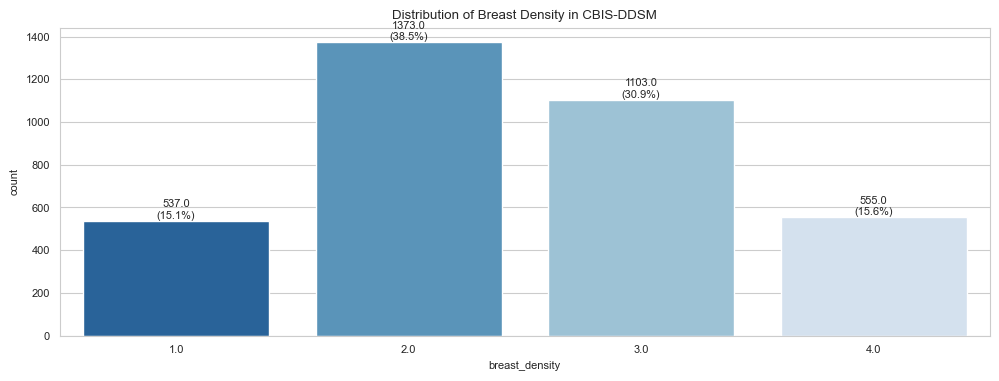

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='breast_density', ax=ax, title ="Distribution of Breast Density in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_breast_density", ax)

```{glue:figure} eda1_univariate_breast_density
---
align: center
name: eda1_univariate_breast_density_fig
---
Distribution of Breast Density in CBIS-DDSM
```

### Left or Right Side

<Axes: title={'center': 'Distribution of Left/Right Breasts in CBIS-DDSM'}, xlabel='laterality', ylabel='count'>

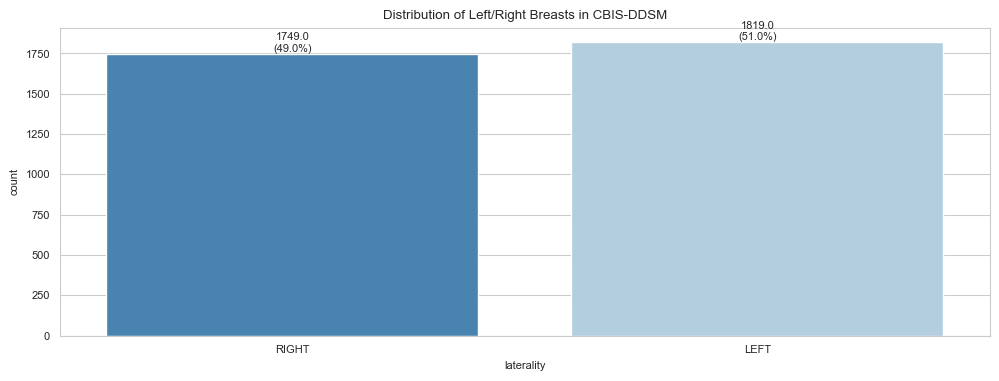

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='laterality', ax=ax, title ="Distribution of Left/Right Breasts in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_laterality", ax)

```{glue:figure} eda1_univariate_laterality
---
align: center
name: eda1_univariate_laterality_fig
---
Distribution of Breast Density in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_laterality_fig` the dataset is approximately balanced with respect to left or right breast images.

### Image View
CBIS-DDSM contains digital mammography images in two different image_views: cranial-caudal (CC) and mediolateral oblique (MLO). The CC image_view is taken from above the breast, and best visualizes the subarcolar, central, medial, and posteromedial aspects of the breast. The MLO projection (side-image_view) images the breast in its entirety and best visualizes the posterior and upper-outer quadrants of the breast {cite}`lilleMammographicImagingPractical2019`.

<Axes: title={'center': 'Distribution of Image View in CBIS-DDSM'}, xlabel='image_view', ylabel='count'>

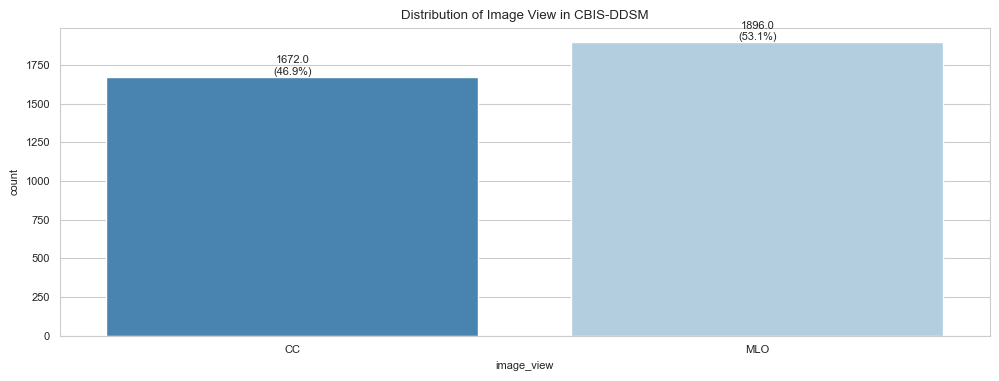

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='image_view', ax=ax, title ="Distribution of Image View in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_view", ax)

```{glue:figure} eda1_univariate_view
---
align: center
name: eda1_univariate_view_fig
---
Distribution of Image View in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_view_fig`, the proportions of CC and MLO image_views are approximately 47% and 53% respectively.

### Abnormality Id
The abnormality id is a sequence number assigned to each abnormality for a patient.

<Axes: title={'center': 'Distribution of Abnormality Counts per Patient in CBIS-DDSM'}, xlabel='abnormality_id', ylabel='count'>

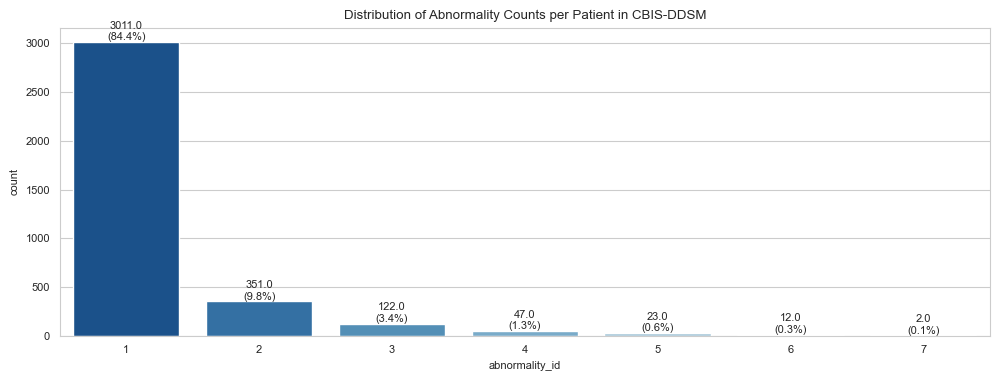

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='abnormality_id', ax=ax, title ="Distribution of Abnormality Counts per Patient in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_abnormality_id", ax)

```{glue:figure} eda1_univariate_abnormality_id
---
align: center
name: eda1_univariate_abnormality_id_fig
---
Distribution of Abnormality Counts per Patient in CBIS-DDSM
```

As indicated in {numref}`eda1_univariate_abnormality_id_fig`, the vast majority of patients present a single abnormality.

### Abnormality Type
CBIS-DDSM contains two abnormality types: calcification and mass.

Calcifications, common on mammograms, especially after age 50, are calcium deposits within the breast tissue. Typically benign, calcifications show up as either macrocalcifications or microcalcifications. Macrocalcifications appear as large white dots or dashes which are almost always noncancerous, requiring no further testing or follow-up. Microcalcifications show up as fine, white specks, similar to grains of salt. Usually noncancerous, but certain patterns can be an early sign of cancer.

Masses are also common, particularly among women of reproductive age. For the 25% of women affected by breast disease in their lifetime, the vast majority will present initially with a new breast mass in the primary care setting. Breast masses have a wide range of causes, from physiological adenosis to highly aggressive malignancy.

<Axes: title={'center': 'Distribution of Abnormality Types in CBIS-DDSM'}, xlabel='abnormality_type', ylabel='count'>

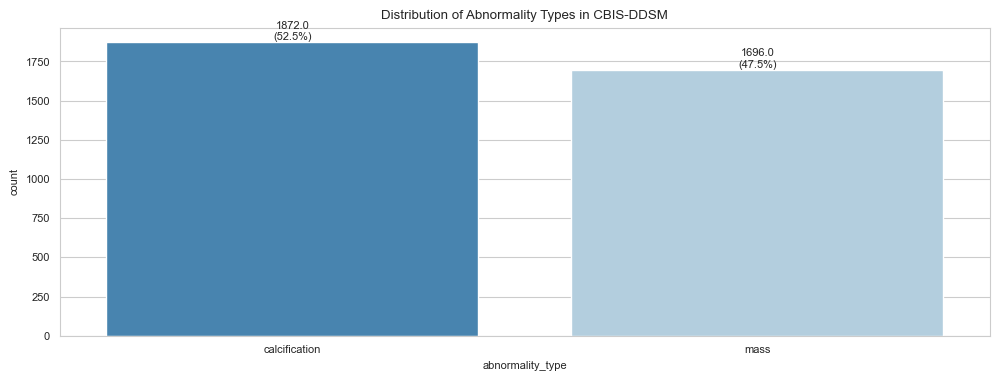

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='abnormality_type', ax=ax, title ="Distribution of Abnormality Types in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_abnormality_type", ax)

```{glue:figure} eda1_univariate_abnormality_type
---
align: center
name: eda1_univariate_abnormality_type_fig
---
Distribution of Abnormality Types in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_abnormality_type_fig`, the dataset contains a balance of calcification and mass cases.

### Subtlety
Subtlety is a measure of the degree to which a particular case is difficult to diagnose. Values range from 1 (highly subtle) to 5 (obvious).

<Axes: title={'center': 'Distribution of Subtlety in CBIS-DDSM'}, xlabel='subtlety', ylabel='count'>

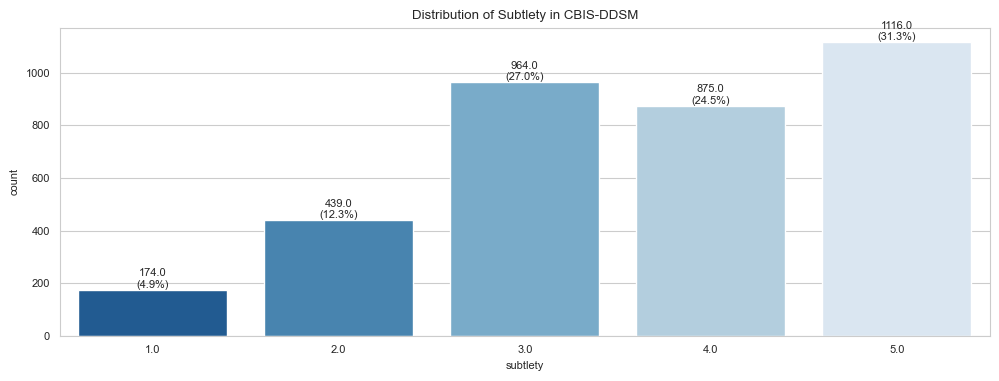

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_subtlety", ax)

```{glue:figure} eda1_univariate_subtlety
---
align: center
name: eda1_univariate_subtlety_fig
---
Distribution of Subtlety in CBIS-DDSM
```

As depicted in {numref}`eda1_univariate_subtlety_fig`, approximately 17% of the cases are highly subtle (1,2). A plurality of cases are moderately to slightly subtle and nearly a 1/3rd of the cases are considered obvious.

### BI-RADS Assessment
A BI-RADS assessment is based upon a thorough evaluation of the mammographic features of concern and has the following six categories {cite}`BreastImagingReporting`:

| Category | Definition                                                                                                                                                         |
|----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0        | Means the findings are unclear. The radiologist will need more images to determine a score                                                                       |
| 1        | Means the findings are negative and the breast tissue appears normal. No masses, calcifications, asymmetry, or other abnormalities have been found.             |
| 2        | Means the findings are benign, which is also negative for cancer. While a   mass, calcification, or other abnormality may have been detected, it’s not cancerous. |
| 3        | Means the findings are probably benign. While a mass, calcification, or other abnormality may have been found, it’s most likely not cancerous.                    |
| 4        | Means cancer is suspected. Four subcategories relate the probability of a malignancy: 4A (2-10%) 4B (10-50%) 4C (50-95%)                       |
| 5        | Means cancer is highly suspected. Findings have a 95% chance or higher of being cancerous.                                                                       |
| 6        | Cancer was previously diagnosed using a biopsy.
                                                                                                                  |

<Axes: title={'center': 'Distribution of BI-RADS Assessment in CBIS-DDSM'}, xlabel='assessment', ylabel='count'>

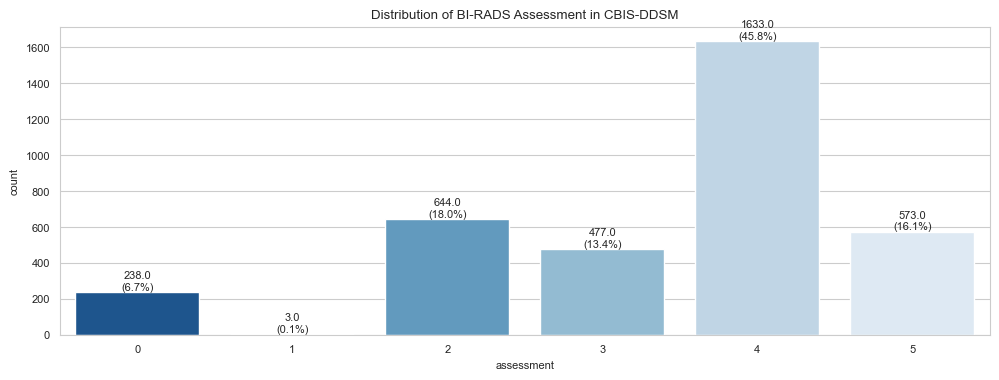

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='assessment', ax=ax, title ="Distribution of BI-RADS Assessment in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_assessment", ax)

```{glue:figure} eda1_univariate_assessment
---
align: center
name: eda1_univariate_assessment_fig
---
Distribution of BI-RADS Assessment in CBIS-DDSM
```

{numref}`eda1_univariate_assessment_fig` indicates a majority of cases in the CBIS-DDSM are suspected or highly suspected of malignancy.

### Calcification Type
Calcification type describes the morphology of a case and is the most important factor in the differentiation between benign and malignant calcifications. There are over 40 different categories of calc_type in the dataset. Some of which are {cite}`BreastImagingReporting`:

| #  | Morphology            |                                                                                                                | Assessment     |
|----|-----------------------|----------------------------------------------------------------------------------------------------------------|----------------|
| 1  | Amorphous             | Indistinct calcifications, without clearly defined shape, small and/or   hazy in appearance                    | BI-RADS 4B     |
| 2  | Coarse Heterogeneous  | Irregular, conspicuous calcifications, typically larger than 0.5 mm.                                           | BI-RADS 3      |
| 3  | Dystrophic            | Irregular, 'lava-shaped', larger than 0.5 mm, which develop 3-5 years   after treatment in about 30% of women. | BI-RADS 1 or 2 |
| 4  | Eggshell              | Very thin benign calcifications that appear as calcium                                                         | BI-RADS 1 or 2 |
| 5  | Fine Linear Branching | Thin linear or curvilinear irregular.                                                                          | BI-RADS 4B     |
| 6  | Large Rod-like        | Benign calcifications that form continuous rods that may occassionally be   branching.                         | BI-RADS 1 or 2 |
| 7  | Lucent-Centered       | Round or oval calcifications, typically result of fat necrosis, or   calcified debris in ducts                 | BI-RADS 1 or 2 |
| 8  | Milk of Calcium       | Benign sedimented calcifications in macro or microcysts.                                                       | BI-RADS 1 or 2 |
| 9  | Pleomorphic           | Calcifications varying in size and shape, more conspicuous than amorphic   calcifications.                     | BI-RADS 4B     |
| 10 | Punctate              | Round calcifications 0.5-1 mm in size.                                                                         | BI-RADS 2,3,4  |
| 11 | Skin                  | Skin calcifications, usually lucent-centered deposits                                                          | BI-RADS 1 or 2 |
| 12 | Vascular              | Linear or form parallel tracks, usually associated with blood vessels.                                         | BI-RADS 1 or 2 |

<Axes: title={'center': 'Distribution of Calcification Types in CBIS-DDSM'}, xlabel='count', ylabel='calc_type'>

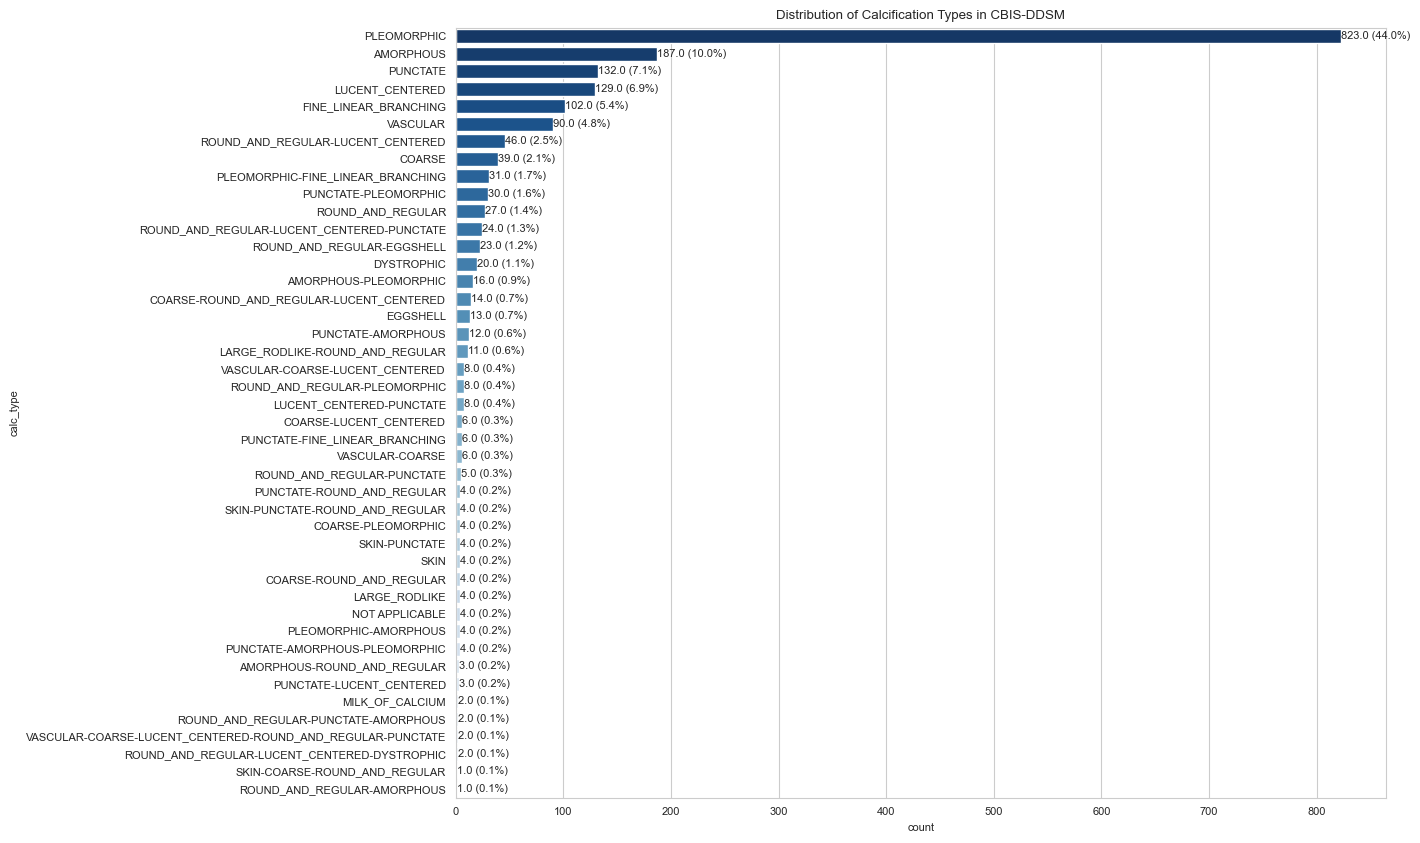

In [14]:
fig, ax = plt.subplots(figsize=(12,10))
ax = calc.plot.countplot(y='calc_type', ax=ax, title ="Distribution of Calcification Types in CBIS-DDSM", plot_counts=True, order_by_count=True)
glue("eda1_univariate_calc_types", ax)

```{glue:figure} eda1_univariate_calc_types
---
align: center
name: eda1_univariate_calc_types_fig
---
Distribution of Calcification Types in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_calc_types_fig`, pleomorphic and amorphous calcifications account for over half of the calcification cases in the dataset. Nearly 75% of the calcification cases are represented by five types.

### Calcification Distribution

Calcification distribution refers to the arrangement of the calcifications inside the breast. BI-RADS describes the following categories of calcification distribution {cite}`BreastImagingReporting`:

1. Diffuse or Scattered: Calcifications throughout the whole breast.
2. Regional: Scattered in a larger volume (> 2 cc) of breast tissue and not in the expected ductal distribution.
3. Clustered: Groups of at least 5 calcifications in a small volume of tissue
4. Segmental: Calcium deposits appear in ducts or branches of a segment or lobe.

<Axes: title={'center': 'Calcification Distributions in CBIS-DDSM'}, xlabel='count', ylabel='calc_distribution'>

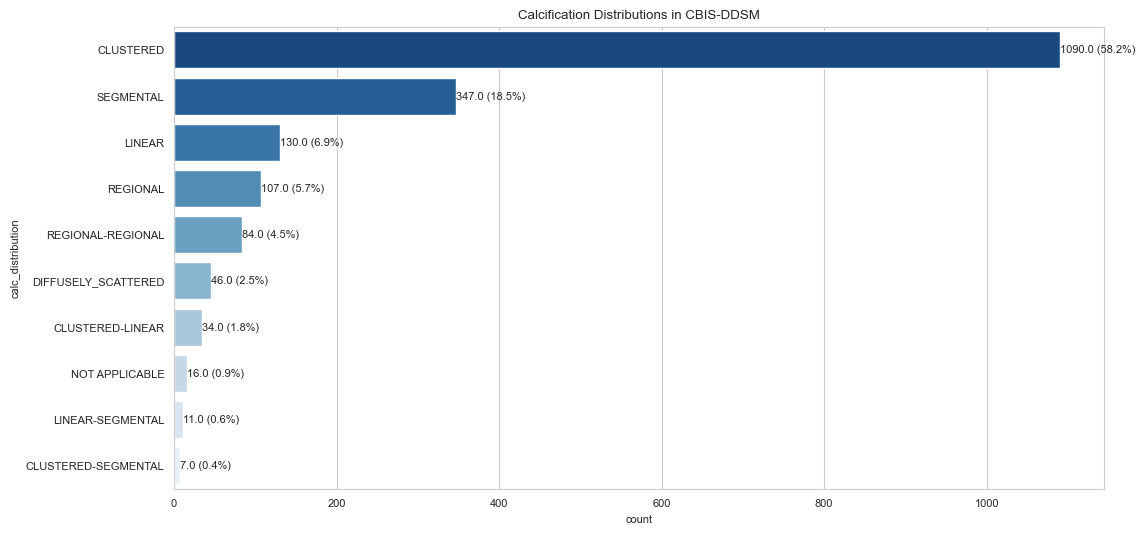

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax = calc.plot.countplot(y='calc_distribution', ax=ax, title ="Calcification Distributions in CBIS-DDSM", plot_counts=True, order_by_count=True)
glue("eda1_univariate_calc_dist", ax)

```{glue:figure} eda1_univariate_calc_dist
---
align: center
name: eda1_univariate_calc_dist_fig
---
Calcification Distributions in CBIS-DDSM
```

As indicated in {numref}`eda1_univariate_calc_dist_fig`, over 80% of the calfication cases have either clustered or segmental distributions.

### Mass Shape
The BI-RADS lexicon defines three mass shapes {cite}`BreastImagingReporting`:
1. Round
2. Oval
3. Irregular

The CBIS-DDSM; however, includes additional categories that further describe the mass shape, symmetry, and architecture.

<Axes: title={'center': 'Distribution of Mass Shapes in CBIS-DDSM'}, xlabel='count', ylabel='mass_shape'>

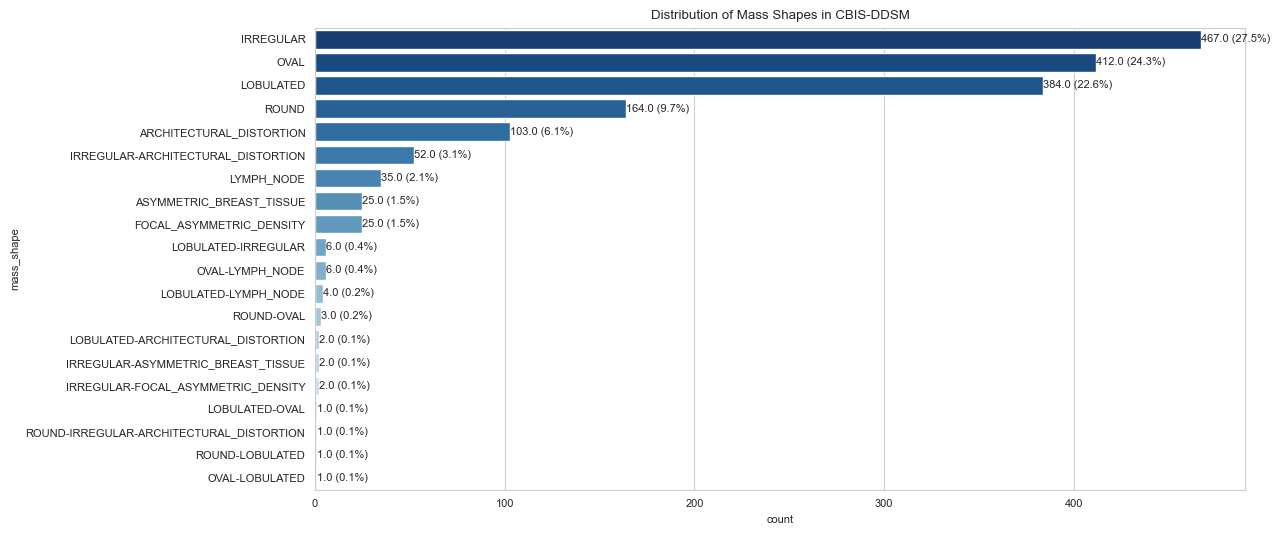

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax = mass.plot.countplot(y='mass_shape', ax=ax, title ="Distribution of Mass Shapes in CBIS-DDSM", plot_counts=True, order_by_count=True)
glue("eda1_univariate_mass_shape", ax)

```{glue:figure} eda1_univariate_mass_shape
---
align: center
name: eda1_univariate_mass_shape_fig
---
Distribution of Mass Shapes in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_mass_shape_fig` the vast majority of mass shapes (84%) are irregular, oval, lobulated, or round.

### Mass Margins

Mass margins are features that separate the mass from the adjacent breast parenchyma. Mass margins can be {cite}`BreastImagingReporting`:

1. Circumscribed: Low probability of malignancy.
2. Obscured: Undetermined likelihood of malignancy.
3. Spiculated: Higher likelihood of malignancy.
4. Microlobulated: Suspicious for breast carcinoma:
5. Ill-Defined: Also called 'indistinct'. Generally suspicious of malignancy.

<Axes: title={'center': 'Distribution of Mass Margins in CBIS-DDSM'}, xlabel='count', ylabel='mass_margins'>

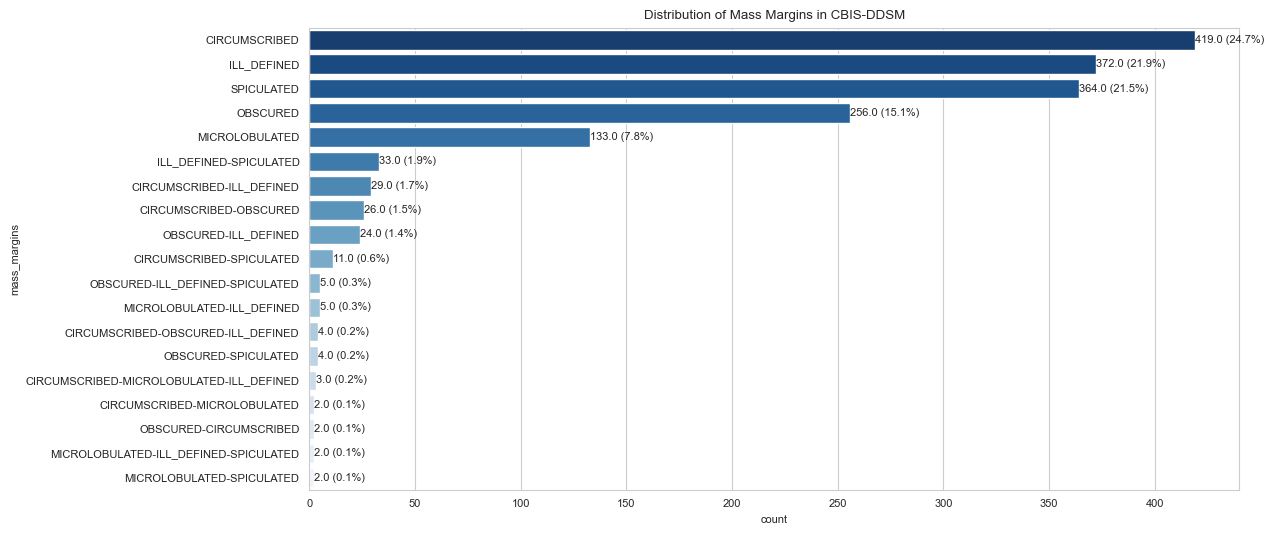

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax = mass.plot.countplot(y='mass_margins', ax=ax, title ="Distribution of Mass Margins in CBIS-DDSM", plot_counts=True, order_by_count=True)
glue("eda1_univariate_mass_margins", ax)

```{glue:figure} eda1_univariate_mass_margins
---
align: center
name: eda1_univariate_mass_margins_fig
---
Distribution of Mass Margins in CBIS-DDSM
```

As depicted in {numref}`eda1_univariate_mass_margins_fig`, spiculated, circumscribed and ill-defined make up nearly 70% of the mass margins in the dataset.

### Pathology
The dataset distinguishes three outcomes: malignant, benign, and benign without callback. The latter indicates that the region may be suspicious, and should be monitored, but no further investigation is required.

<Axes: title={'center': 'Distribution of Pathology in CBIS-DDSM'}, xlabel='pathology', ylabel='count'>

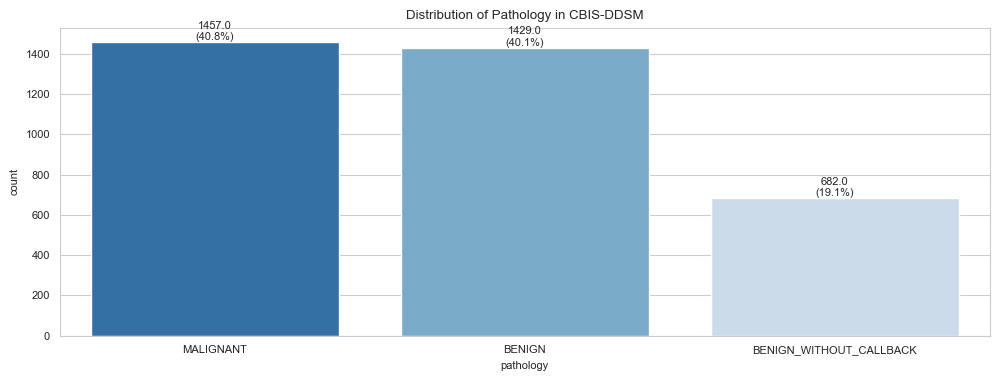

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology in CBIS-DDSM", plot_counts=True, order_by_count=True)
glue("eda1_univariate_pathology", ax)

```{glue:figure} eda1_univariate_pathology
---
align: center
name: eda1_univariate_pathology_fig
---
Distribution of Pathology in CBIS-DDSM
```

As shown in {numref}`eda1_univariate_pathology_fig`, the majority of cases are benign (~60%), indicating a slight class imbalance.

### Cancer
In {numref}`eda1_univariate_cancer_fig`, we collapse BENIGN and BENIGN_WITHOUT_CALLBACK into a single category.

<Axes: title={'center': 'Distribution of Cancer Diagnoses in CBIS-DDSM'}, xlabel='cancer', ylabel='count'>

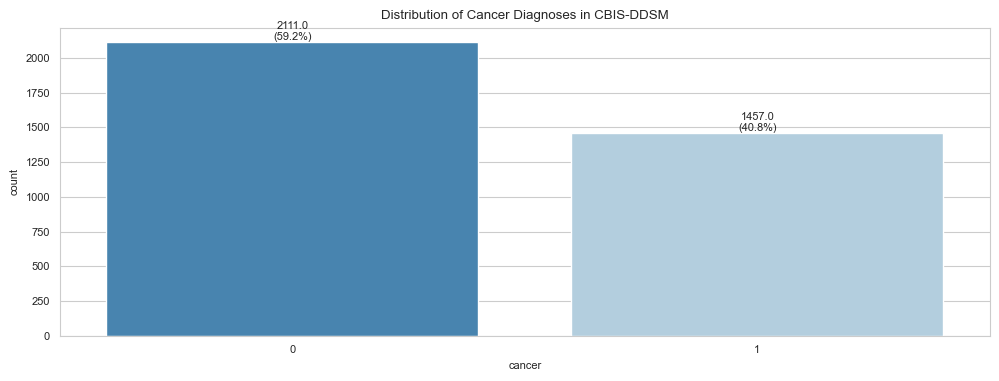

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ax = cases.plot.countplot(x='cancer', ax=ax, title ="Distribution of Cancer Diagnoses in CBIS-DDSM", plot_counts=True)
glue("eda1_univariate_cancer", ax)

```{glue:figure} eda1_univariate_cancer
---
align: center
name: eda1_univariate_cancer_fig
---
Distribution of Cancer Diagnoses in CBIS-DDSM
```

### Summary CBIS-DDSM Case Univariate Analysis

Several observations can be made at this stage.

1. The CBIS-DDSM is well-balanced for breast side, image view, and abnormality type.
2. The majority (~70%) of cases have BI-RADS b and c breast densities, the remainder is evenly split between BI-RADS a and d densities.
3. Calcification Cases
   1. Pleomorphic, amorphous, punctate, lucent-centered, and fine linear branching calcification types account for ~75% of the calcification case types in the dataset. Pleomorphic calcifications represent a plurality (~44%).
   2. Clustered and segmental calcification distributions account for ~85% of the calcification distributions in the dataset.
4. Mass Cases
   1. Irregular, oval, lobulated, and round masses account for ~85% of the mass cases.
   2. Spiculated, circumscribed, ill-defined, obscured, and microlobulated mass margins account for ~93% of the mass margins in the dataset.
5. Approximately 60% of the cases are benign, indicating a slight class imbalance which could lead to biased predictions.

Next up? Bivariate analysis.

## Bivariate Analysis

This bivariate analysis will comprise a dependence analysis and an inter-dependence analysis.  The former assesses the degree to which a cancer diagnosis depends upon the values of the explanatory variables, such as breast density, type and distribution of calcifications, and the shape and margins of masses. The inter-dependence analysis explores the association between two independent variables.

In [20]:
df = cases.as_df(categorize_ordinals=True)

### Bivariate Target Variable Association Analysis

#### Cancer Diagnosis by Breast Density

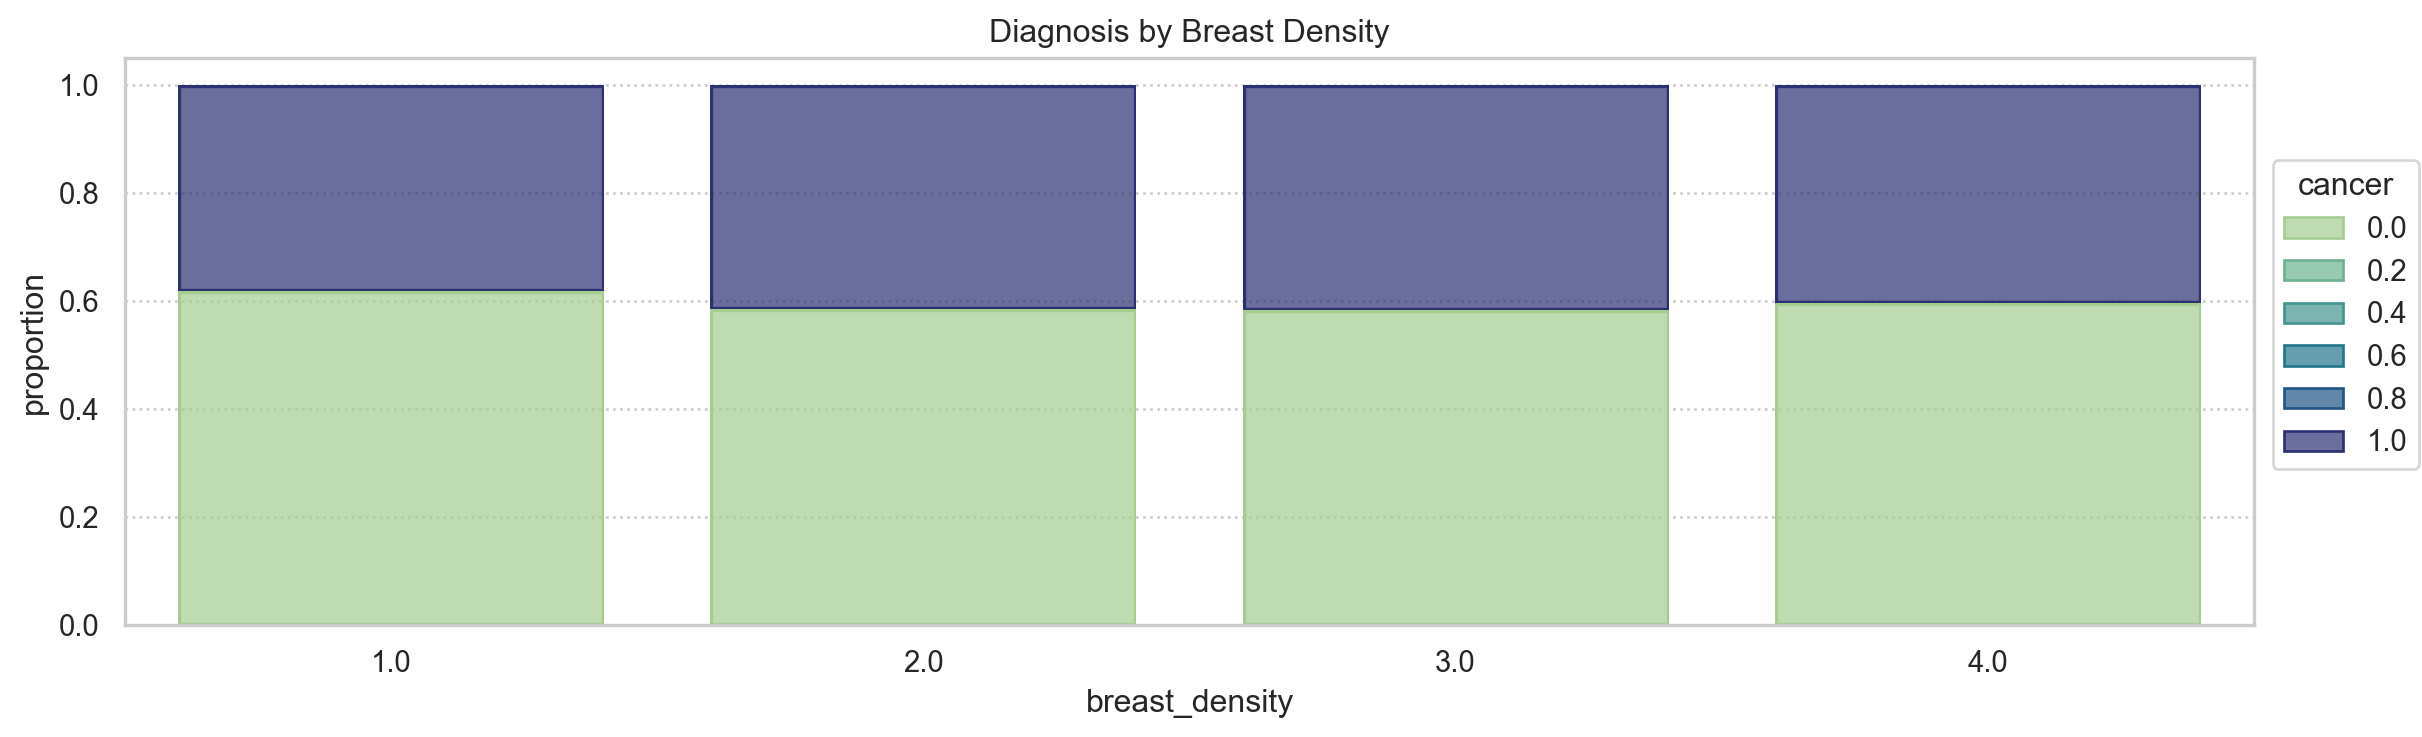

In [21]:
prop = df[['breast_density', 'cancer']].groupby(by=['breast_density']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['breast_density','cancer'])
p = sns.objects.Plot(prop, x='breast_density', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Density").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_density", p)

```{glue:figure} eda1_bivariate_density
---
align: center
name: eda1_bivariate_density_fig
---
Diagnosis by Breast Density
```

Breast density is considered a risk factor for breast cancer, as women with dense breasts have a higher risk of breast cancer than women with fatty breasts {cite}`DenseBreastsAnswers2018`. Notwithstanding, {numref}`eda1_bivariate_density_fig` doesn't reveal a strong relationship between breast density and diagnosis. Let's see if a test of association supports our inference.

In [22]:
kt = cases.stats.kendallstau(a='breast_density', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.011830684811679301
                          Pvalue | 0.5132100837894994
                           Alpha | 0.05
                               A | breast_density
                               B | cancer
                               N | 3568
                        Strength | Weak




The Kendall's Tau test measuring the association between breast density and malignancy indicated a non-significant association of weak effect, ($\phi_\tau$ = 0.01, p = 0.54).

#### Cancer Diagnosis by Breast Side

A 2022 study published in Nature {cite}`abdouLeftSidedBreast2022` suggests that breast cancer is slightly more prevalent on the left side of the body than it is on the right. Do the CBIS-DDSM data support this finding?

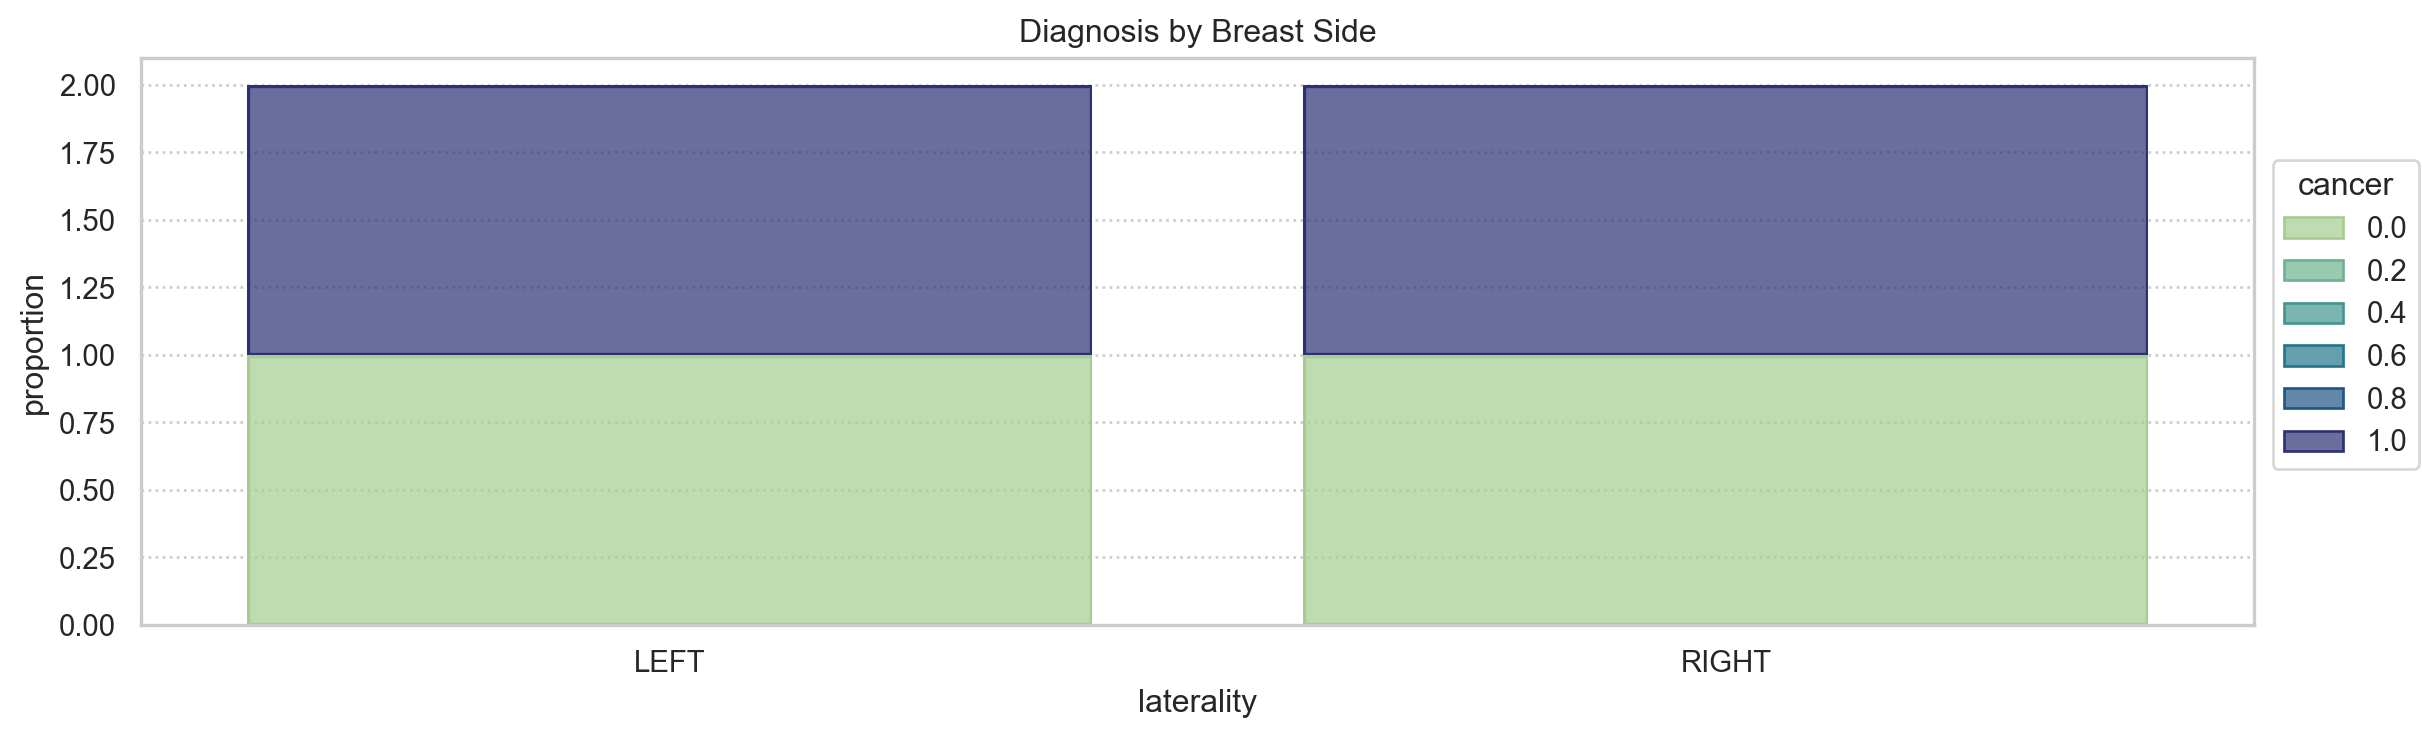

In [23]:
prop = df[['laterality', 'cancer']].groupby(by=['laterality']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['laterality','cancer'])
p = sns.objects.Plot(prop, x='laterality', y='proportion', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Side").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_left_right", p)

```{glue:figure} eda1_bivariate_left_right
---
align: center
name: eda1_bivariate_left_right_fig
---
Diagnosis by Breast Side
```

If there is a slightly greater risk of cancer in the left breast, it is not evident in {numref}`eda1_bivariate_left_right_fig`. Let's test the hypothesis.

In [24]:
cv = cases.stats.cramersv(a='laterality', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.02932260658753906
                          Pvalue | 0.07985645167706741
                           Alpha | 0.05
                        Strength | Negligible
                               A | laterality
                               B | cancer
                               N | 3568
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 3.067820837288518
                           X2dof | 1




The chi-square test above, indicates a non-significant association of negligible effect between breast and diagnosis, ($X^2$ (1,n=3566)=2.97 p=0.08, $\phi$=.03).

#### Cancer by Image View

A study published in RSNA Journals {cite}`korhonenBreastCancerConspicuity2019` analyzed breast cancer conspicuity by image_view and determined that cancers were more likely to have high conspicuity in the craniocaudal (CC) than in the mediolateral oblique (MLO) image view.  Does this imply a higher proportion of malignancies detected in the CC view? Let's see what our data suggest.

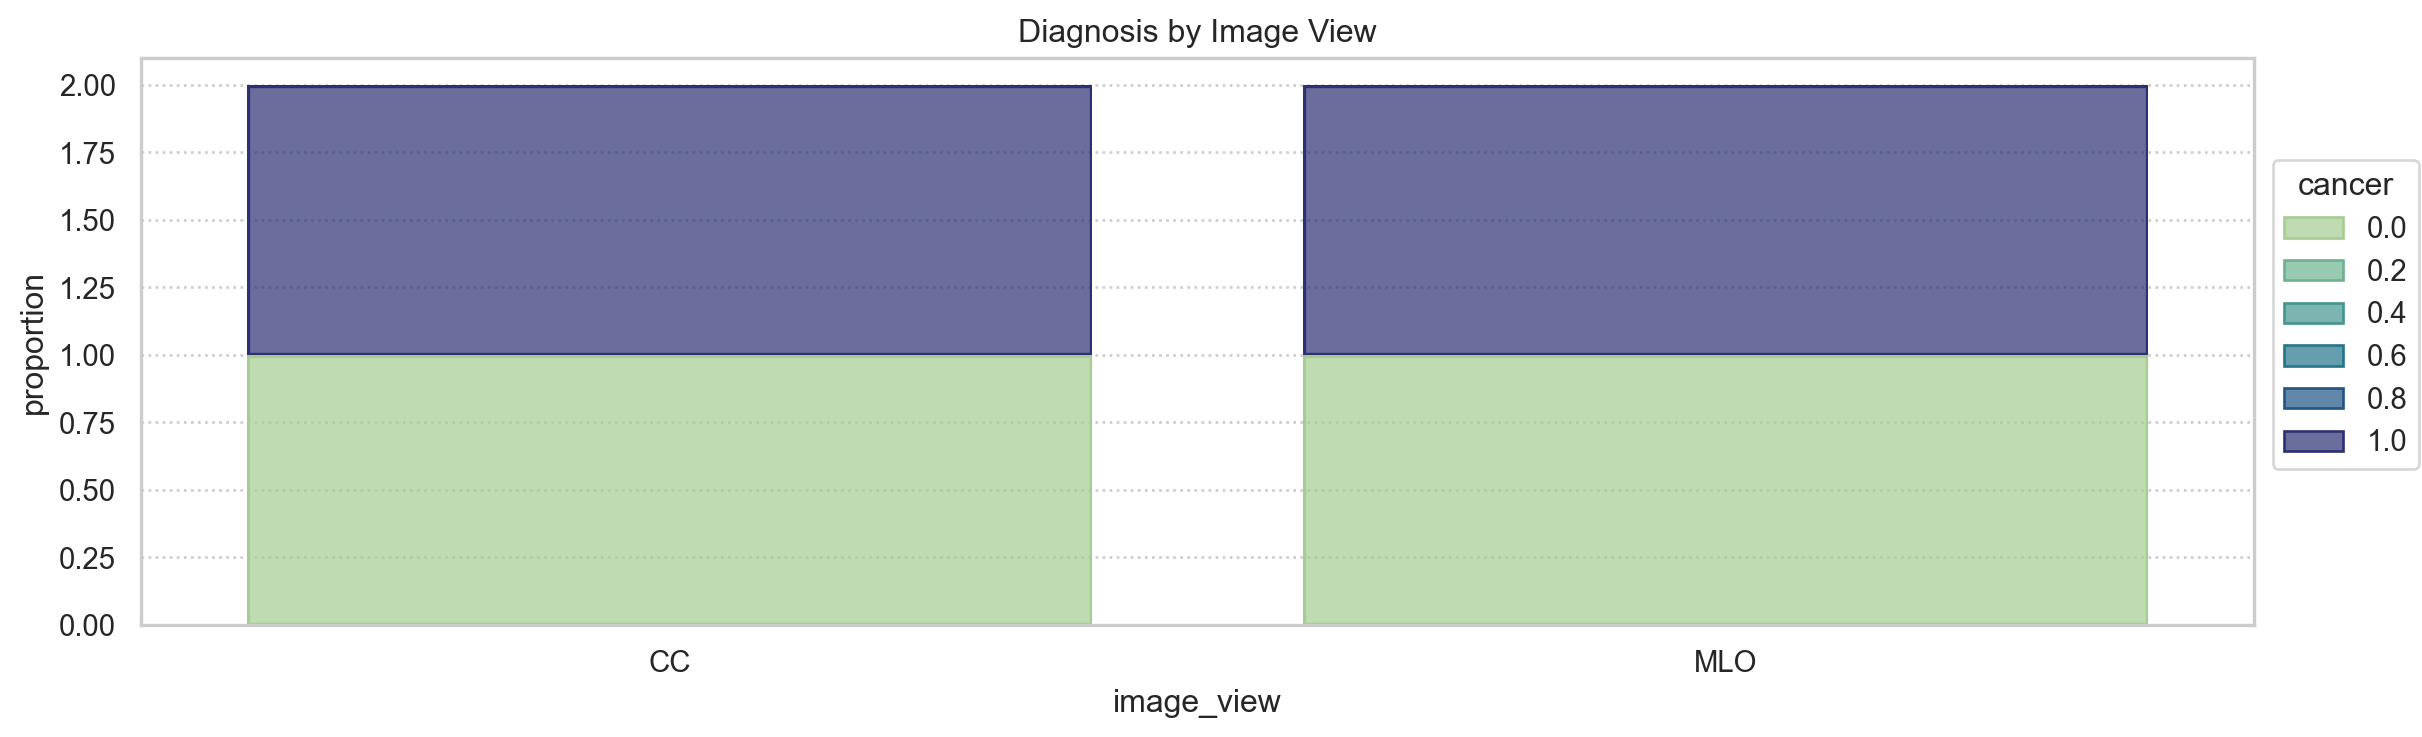

In [25]:
prop = df[['image_view', 'cancer']].groupby(by=['image_view']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['image_view','cancer'])
p = sns.objects.Plot(prop, x='image_view', y='proportion', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Image View").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_view", p)

```{glue:figure} eda1_bivariate_view
---
align: center
name: eda1_bivariate_view_fig
---
Diagnosis by Image View
```

{numref}`eda1_bivariate_view_fig` suggests no difference in malignancies detected in the CC and MLO views.

In [26]:
cv = cases.stats.cramersv(a='image_view', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.0014449668887015286
                          Pvalue | 0.9312185356134342
                           Alpha | 0.05
                        Strength | Negligible
                               A | image_view
                               B | cancer
                               N | 3568
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 0.007449731776095392
                           X2dof | 1




The chi-square test above, indicates a non-significant association of negligible effect between image image_view and diagnosis, ($X^2$ (1,n=3566)=0.007 p=0.93, $\phi$=.002).

#### Cancer by Abnormality Type

Is abnormality type an indicator of malignancy?

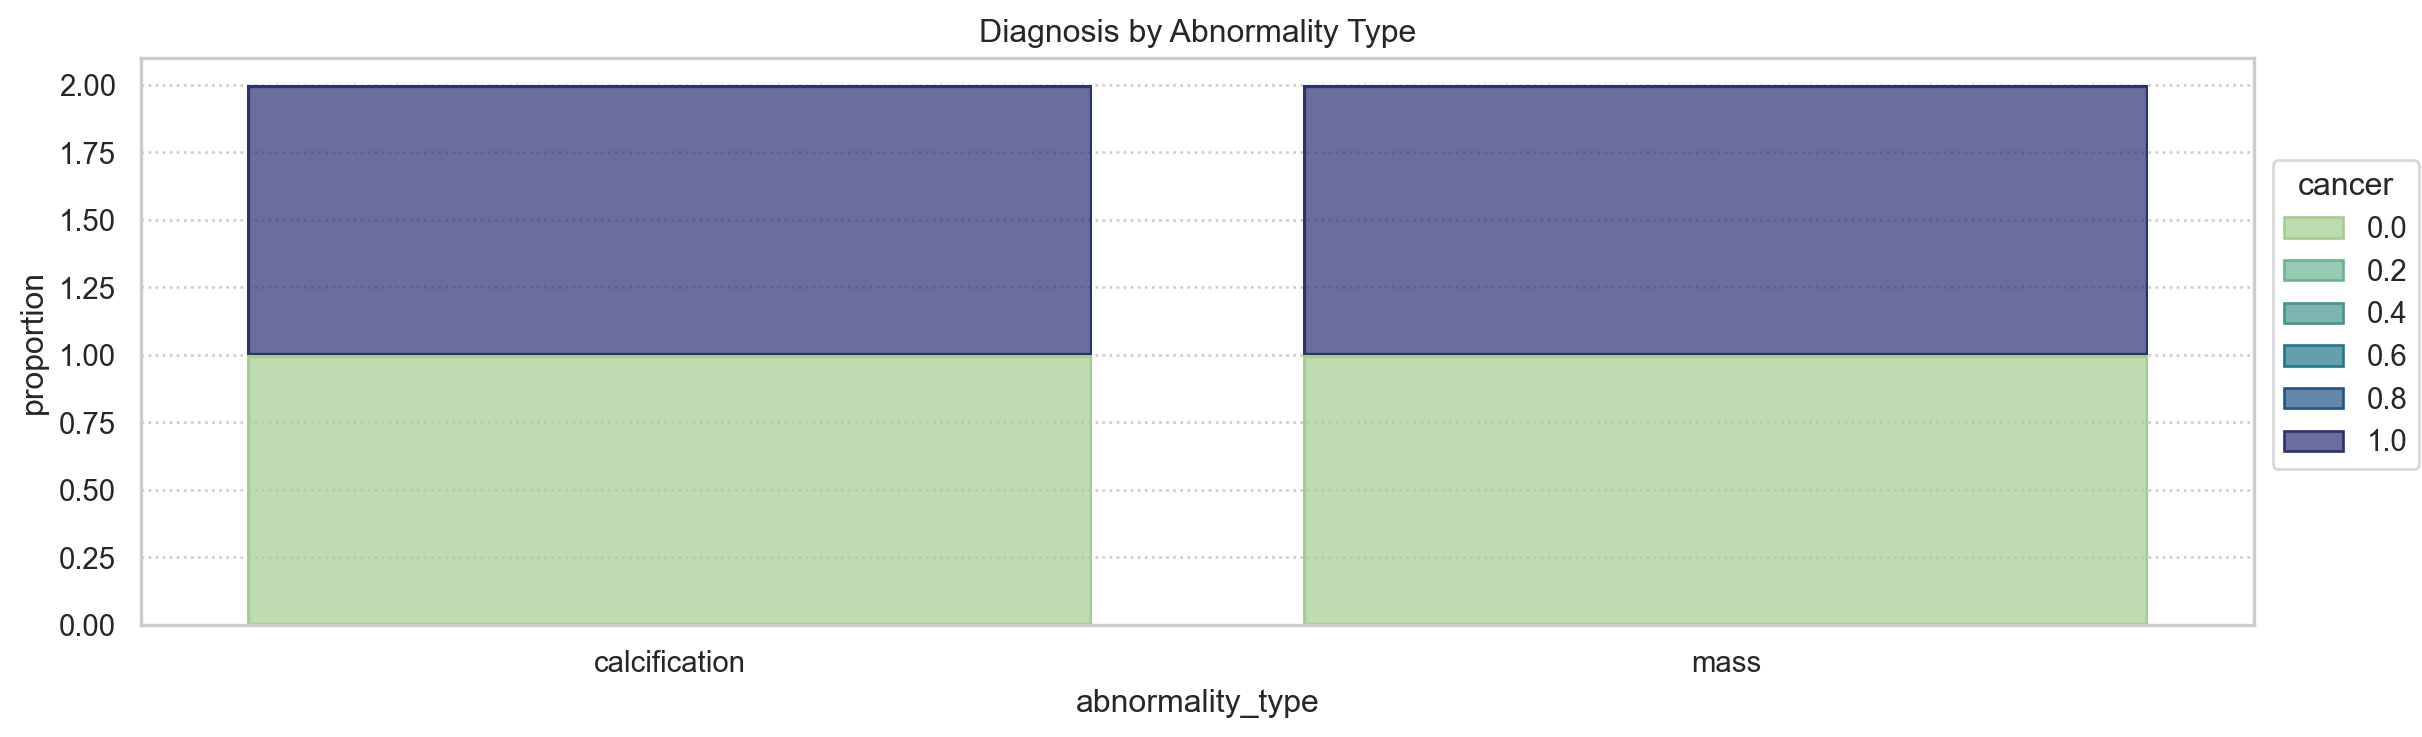

In [27]:
prop = df[['abnormality_type', 'cancer']].groupby(by=['abnormality_type']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['abnormality_type','cancer'])
p = sns.objects.Plot(prop, x='abnormality_type',y='proportion', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Abnormality Type").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_abtype", p)

```{glue:figure} eda1_bivariate_abtype
---
align: center
name: eda1_bivariate_abtype_fig
---
Diagnosis by Abnormality Type
```

{numref}`eda1_bivariate_abtype_fig` indicates that the probability of a malignancy is slightly higher for masses than for calcifications. Is this significant?

In [28]:
cv = cases.stats.cramersv(a='abnormality_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.10382837836069872
                          Pvalue | 5.576661669806515e-10
                           Alpha | 0.05
                        Strength | Small
                               A | abnormality_type
                               B | cancer
                               N | 3568
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 38.46422512194828
                           X2dof | 1




The chi-square test above, indicates a significant association of small effect between abnormality type and diagnosis, ($X^2$ (1,n=3566)=38.85 p<0.01, $\phi$=.10). More malignancies were diagnosed among the mass cases, compared to calcifications (54% vs 46%). However, the size of the effect is small.

#### BI-RADS Assessment and Cancer
To what degree is there (dis)agreement between the BI-RADS assessment the diagnosis. The BI-RADS assessment is an overall summary of the mammography report and has seven categories.

| Label | Description                                                                              | Likelihood of Cancer                                                        |
| ----- | ---------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| 0     | Incomplete . Need Additional   Imaging Evaluation and/or Prior Mammograms for Comparison | NA                                                                          |
| 1     | Negative Routine mammography                                                             | Essentially 0% likelihood of malignancy                                     |
| 2     | Benign Routine mammography                                                               | Essentially 0% likelihood of malignancy                                     |
| 3     | Probably Benign Short-interval   (6-month)                                               | > 0% but . 2% likelihood of malignancy                                      |
| 4     | Suspicious                                                                               | Low: 2% to ≤ 10%      Moderate: > 10% to ≤ 50%       High: > 50% to < 95% |
| 5     | Highly Suggestive of Malignancy                                                          | > 95% likelihood of malignancy                                              |
| 6     | Known Biopsy-Proven Malignancy                                                           | NA                                                                          |

To what degree is there agreement between the BI-RADS assessments and diagnosis.

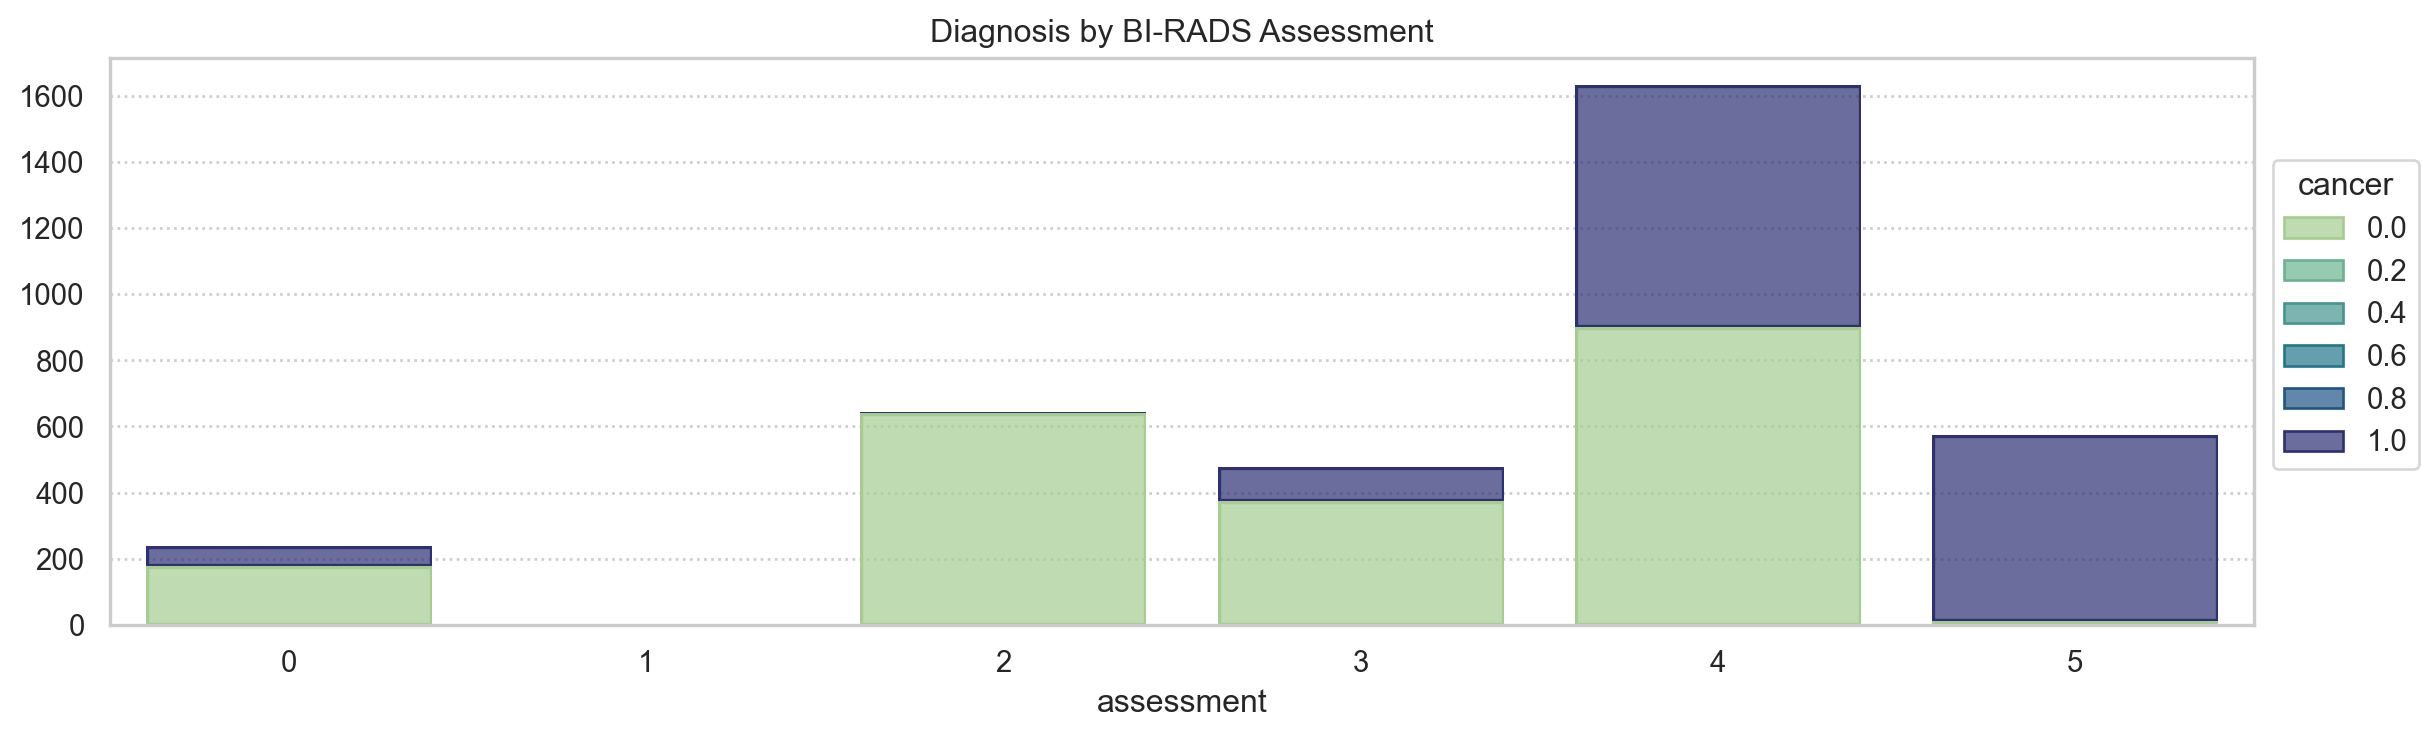

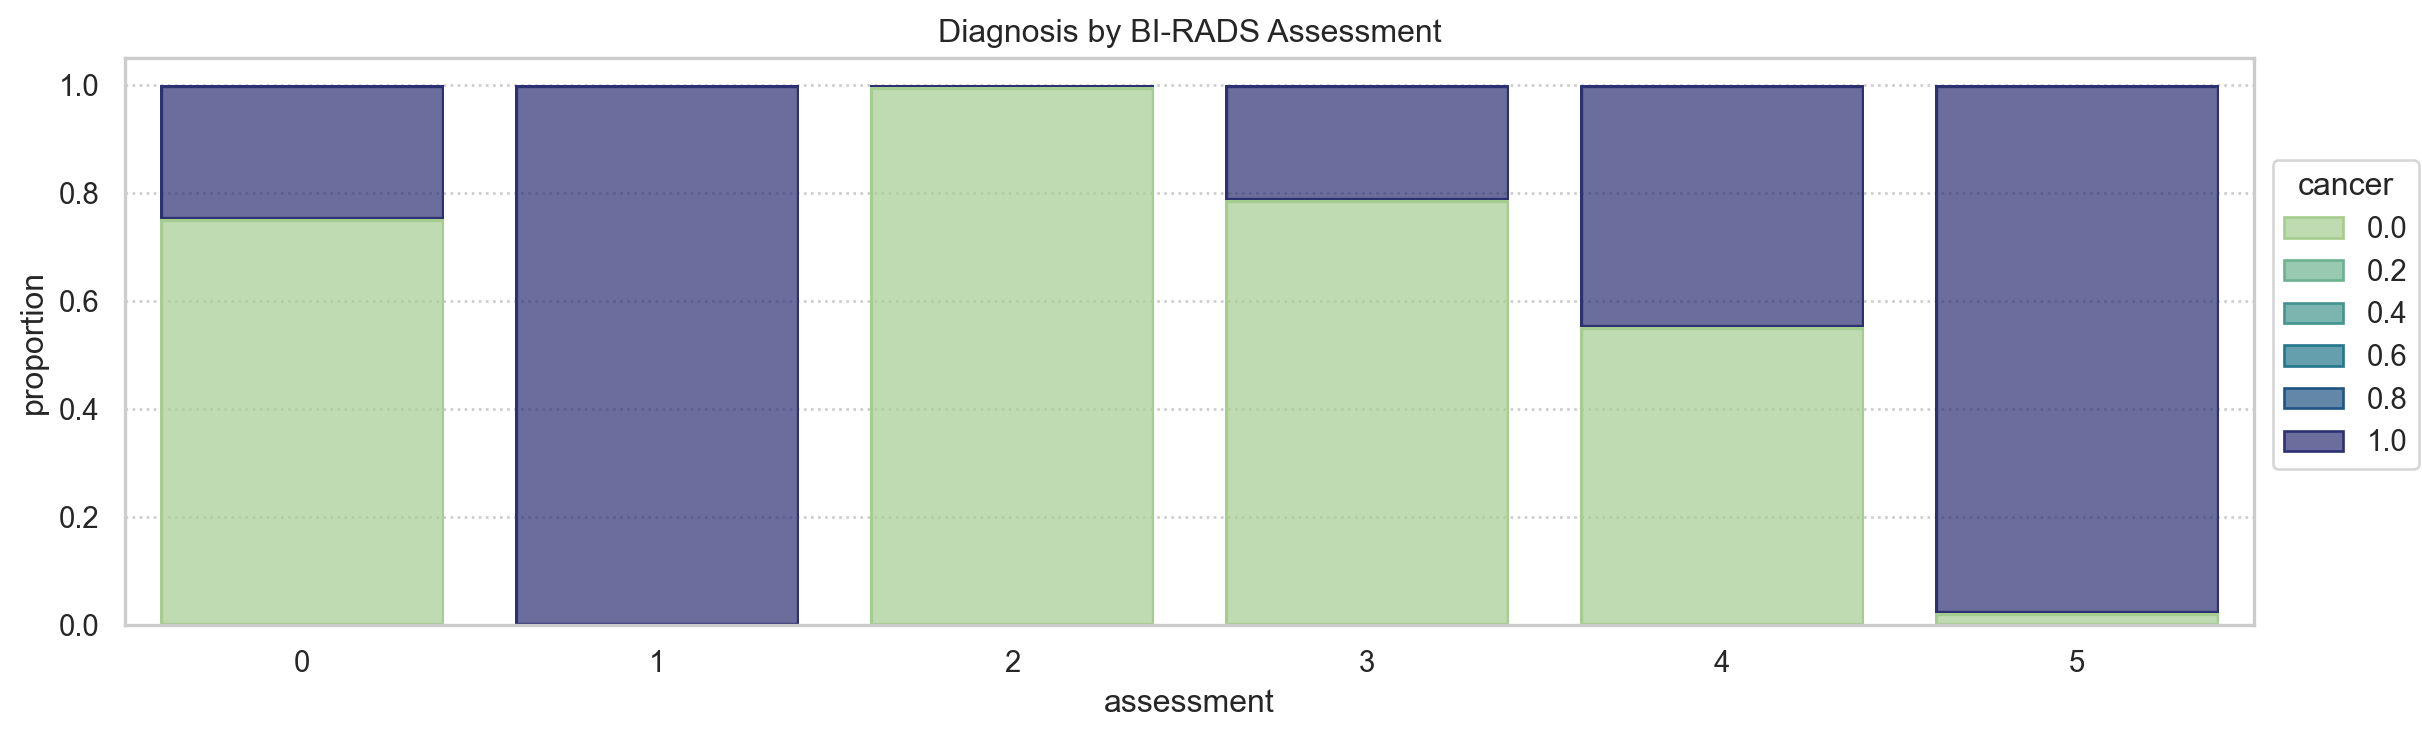

In [29]:
p1 = sns.objects.Plot(df, x='assessment', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight').scale(color='crest')
prop = df[['assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['assessment','cancer'])
p2 = sns.objects.Plot(prop, x='assessment', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight').scale(color='crest')

glue("eda1_bivariate_assessment_count", p1)
glue("eda1_bivariate_assessment_prop", p2)

```{glue:figure} eda1_bivariate_assessment_count
---
align: center
name: eda1_bivariate_assessment_count_fig
---
Diagnosis by BI-RADS Assessment (Count)
```

```{glue:figure} eda1_bivariate_assessment_prop
---
align: center
name: eda1_bivariate_assessment_prop_fig
---
Diagnosis by BI-RADS Assessment (Proportion)
```

{numref}`eda1_bivariate_assessment_count_fig` and {numref}`eda1_bivariate_assessment_prop_fig` suggest a relationship between BI-RADS assessment and diagnosis. Let's evaluate the effect size.

In [30]:
kt = cases.stats.kendallstau(a='assessment', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.599686551107
                          Pvalue | 7.40611178553895e-245
                           Alpha | 0.05
                               A | assessment
                               B | cancer
                               N | 3568
                        Strength | Strong




Indeed, the Kendall's Tau test above, indicates a significant association of strong effect between BI-RADS assessment and diagnosis, ($\phi_\tau$=0.60, p<0.01).

Several observations are worth note:

1. There were only three BI-RADS Category 1 assessments.
2. Category 2 assessments, were all negative for cancer.
3. Approximately 20% of the BI-RADS category 3, probably benign, were ultimately diagnosed as malignant.
4. Suspicious cases (BI-RADS 4) were nearly 50/50 benign/malignant.
5. Just 2% of the highly suspicious cases were benign.

##### Subtlety and Cancer
Are malignancies more or less conspicuous?

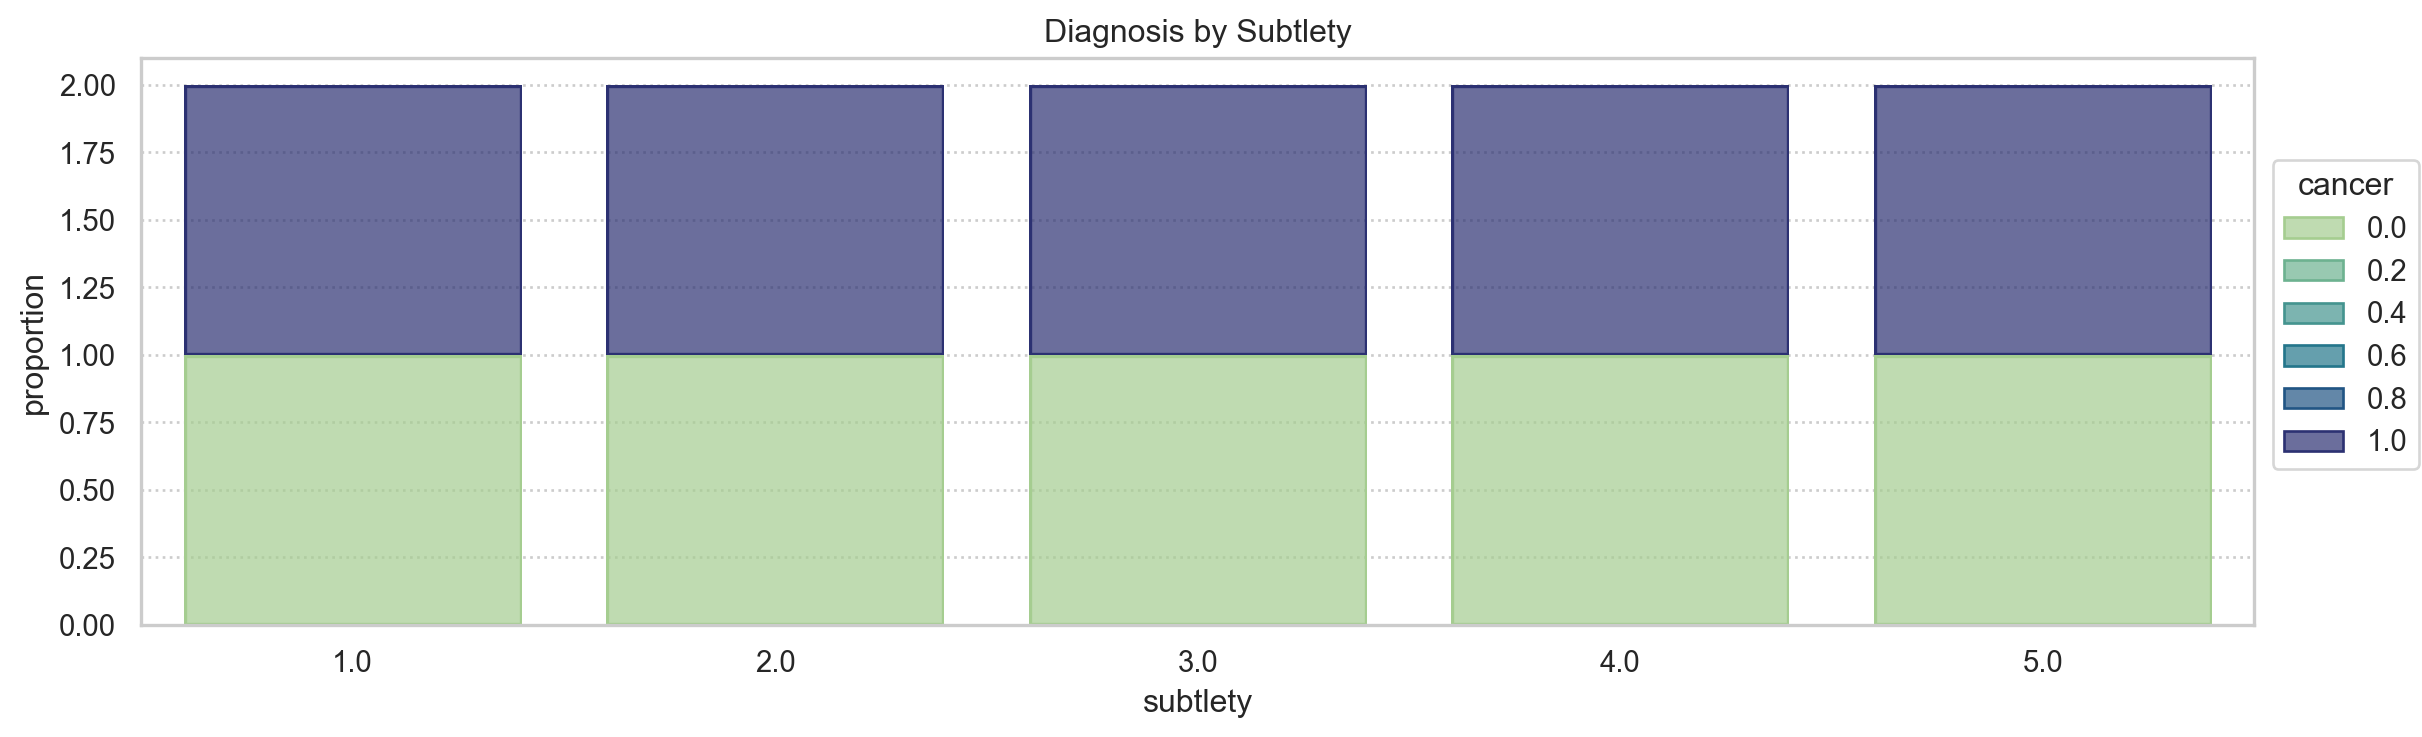

In [31]:
prop = df[['subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['subtlety','cancer'])
p = sns.objects.Plot(prop, x='subtlety', y='proportion', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Subtlety").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_subtlety", p)

```{glue:figure} eda1_bivariate_subtlety
---
align: center
name: eda1_bivariate_subtlety_fig
---
Diagnosis by Subtlety
```

Based upon {numref}`eda1_bivariate_subtlety_fig`, it would be difficult to draw an inference of association between subtlety and diagnosis. Let's test the effect of subtlety on diagnosis.

In [32]:
kt = cases.stats.kendallstau(a='subtlety', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.0025924887892376683
                          Pvalue | 0.8876975744567236
                           Alpha | 0.05
                               A | subtlety
                               B | cancer
                               N | 3568
                        Strength | Weak




The Kendall's Tau test measuring the association between subtlety and malignancy indicated a non-significant association of weak effect, $\phi_\tau$ = 0.003, p = 0.86.

#### Calcification Type and Cancer
What is the association between calcification type and malignancy. For this analysis, we'll focus on the top five calcification types in the CBIS-DDSM: pleomorphic, amorphous, pnctate, lucent-centered and fine linear branching.

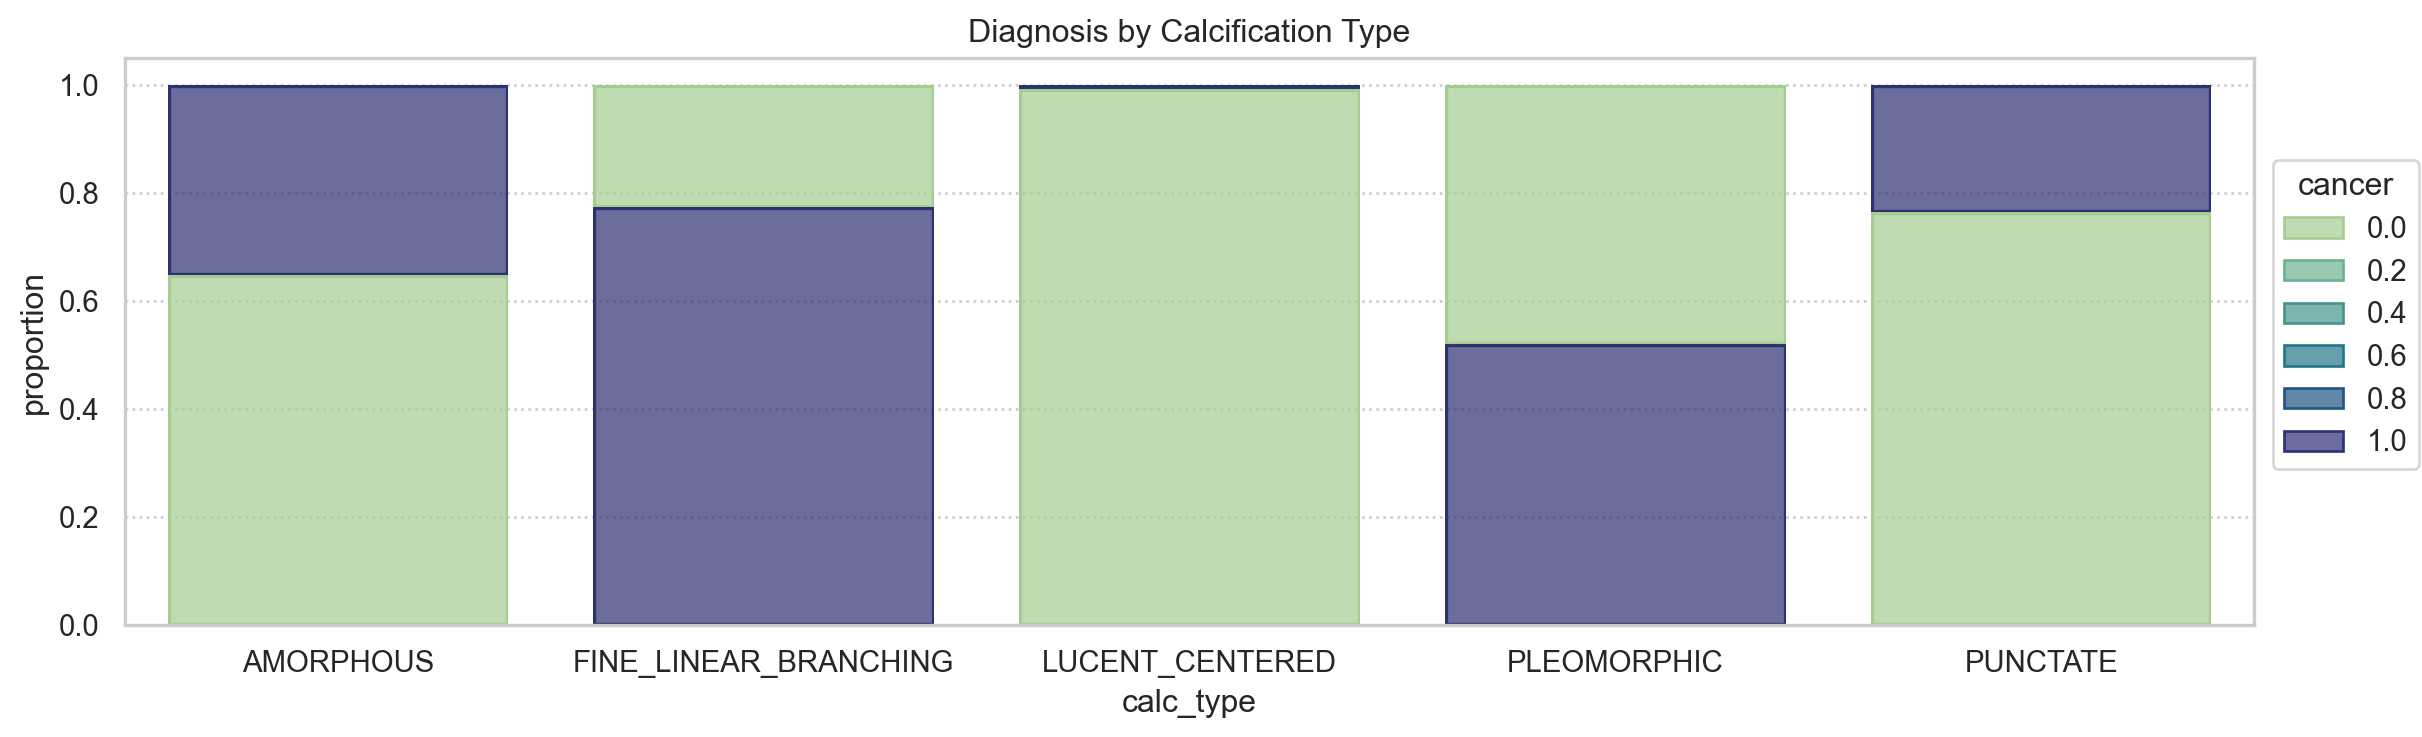

In [33]:
df_calc = calc.as_df()
df_calc['calc_type'] = df_calc['calc_type'].astype(str)
df_calc = df_calc.loc[df_calc['calc_type'].isin(['PLEOMORPHIC', 'AMORPHOUS', 'PUNCTATE', 'LUCENT_CENTERED', 'FINE_LINEAR_BRANCHING'])].reset_index()
prop = df_calc[['calc_type', 'cancer']].groupby(by=['calc_type']).value_counts(normalize=True).to_frame().reset_index()
p = sns.objects.Plot(prop, x='calc_type', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":" }).label(title="Diagnosis by Calcification Type").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_calc_type", p)

```{glue:figure} eda1_bivariate_calc_type
---
align: center
name: eda1_bivariate_calc_type_fig
---
Diagnosis by Calcification Type
```

Fine linear branching, pleomorphic, and amorphous calcifications have the highest rates of malignancy. Punctate calcifications are of some concern; whereas, lucent centered calcifications appear to indicate a benign pathology. Let's evaluate the effect of calcification type on pathology.

In [34]:
cv = calc.stats.cramersv(a='calc_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5344131649818471
                          Pvalue | 4.453725789334954e-86
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 534.6383906558727
                           X2dof | 43




Cramer's V indicates a large effect ($X^2$(1,n=1872)=539.69 p<0.01, $V$=0.54).

{numref}`eda1_bivariate_calc_types_top_10_fig` lists the top 10 most malignant calcification types by proportion in the CBIS-DDSM.

<Axes: title={'center': 'Malignancy by Calcification Type'}, xlabel='proportion', ylabel='calc_type'>

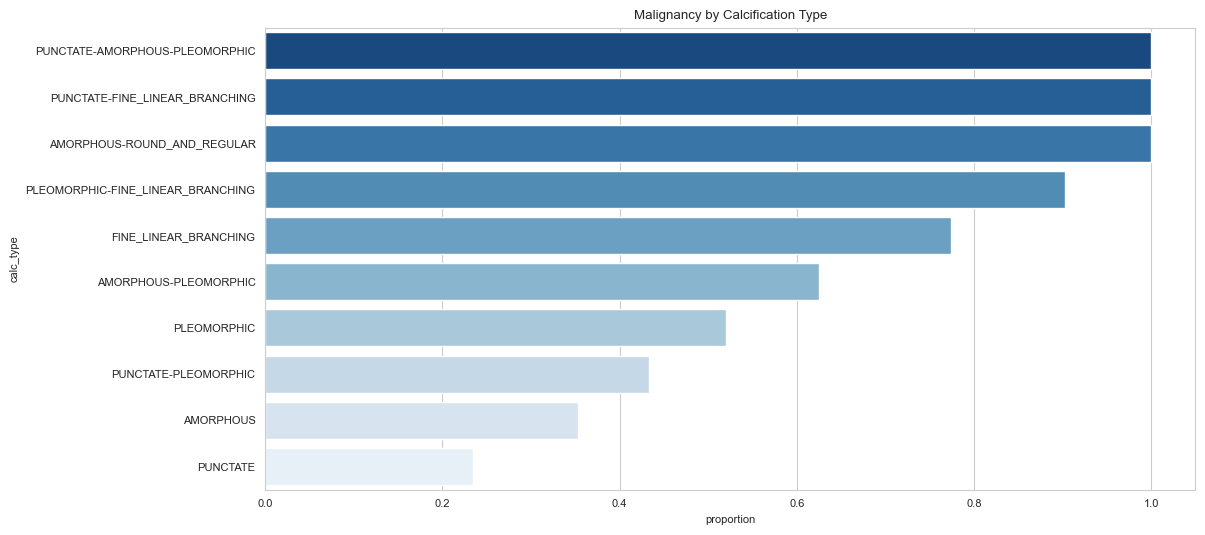

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
calc_types = cases.get_most_malignant_calc(x='calc_type', n=10)
ax = calc.plot.barplot(data=calc_types, y='calc_type', x='proportion', title='Malignancy by Calcification Type', ax=ax)
glue("eda1_bivariate_calc_types_top_10", ax)

```{glue:figure} eda1_bivariate_calc_types_top_10
---
align: center
name: eda1_bivariate_calc_types_top_10_fig
---
Most Malignant Calcification Types
```

#### Calcification Distribution
How do we characterize the association between calcification distribution and malignancy? For this analysis, we will focus on clustered, segmental, linear, regional, and diffusely scattered calcification distributions.

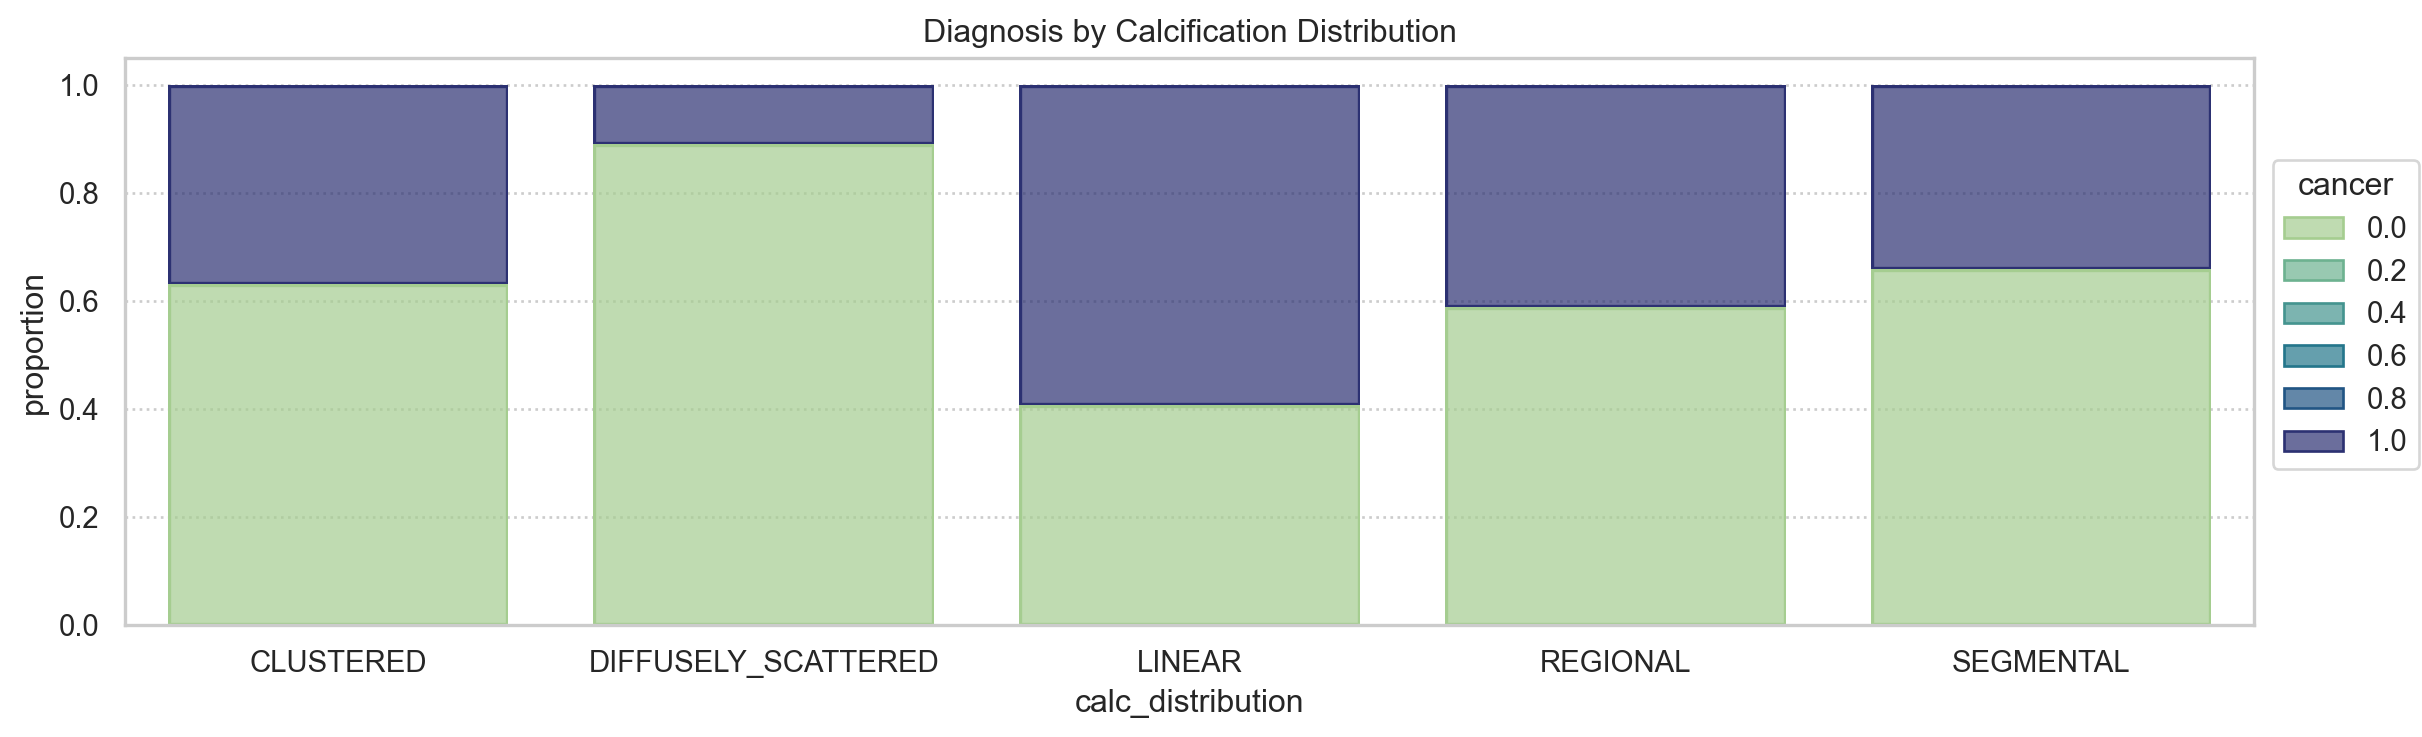

In [36]:
df_calc = calc.as_df()
df_calc['calc_distribution'] = df_calc['calc_distribution'].astype(str)
df_calc = df_calc.loc[df_calc['calc_distribution'].isin(['CLUSTERED', 'SEGMENTAL', 'LINEAR', 'REGIONAL', 'DIFFUSELY_SCATTERED'])].reset_index()
prop = df_calc[['calc_distribution', 'cancer']].groupby(by=['calc_distribution']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['calc_distribution','cancer'])
p = sns.objects.Plot(prop, x='calc_distribution', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Calcification Distribution").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_calc_dist", p)

```{glue:figure} eda1_bivariate_calc_dist
---
align: center
name: eda1_bivariate_calc_dist_fig
---
Diagnosis by Calcification Distribution
```

Linear, regional, and clustered calcifications have the highest rates of malignancy. Segmental and diffusely scattered calcifications tend to indicate a benign diagnosis in this dataset.

The Cramer's V test below provides a measure of the effect of calcification distribution on diagnosis.

In [37]:
cv = calc.stats.cramersv(a='calc_distribution', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.25198949452242214
                          Pvalue | 2.276084066734899e-21
                           Alpha | 0.05
                        Strength | Small
                               A | calc_distribution
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 118.8695764145744
                           X2dof | 9




This chi-square test of independence between calcification distribution and diagnosis indicates a moderate and significant association ($X^2$(1,n=1872)=198.56 p<0.01, $V$=0.33).

#### Mass Shape and Cancer

Mass shape and mass margins are the most significant features that indicate whether a mass is benign or malignant {cite}`bassettAbnormalMammogram2003`. Here, we will focus on the top five mass shapes in the CBIS-DDSM: irregular, oval, lobulated, round, and architectural distortion.

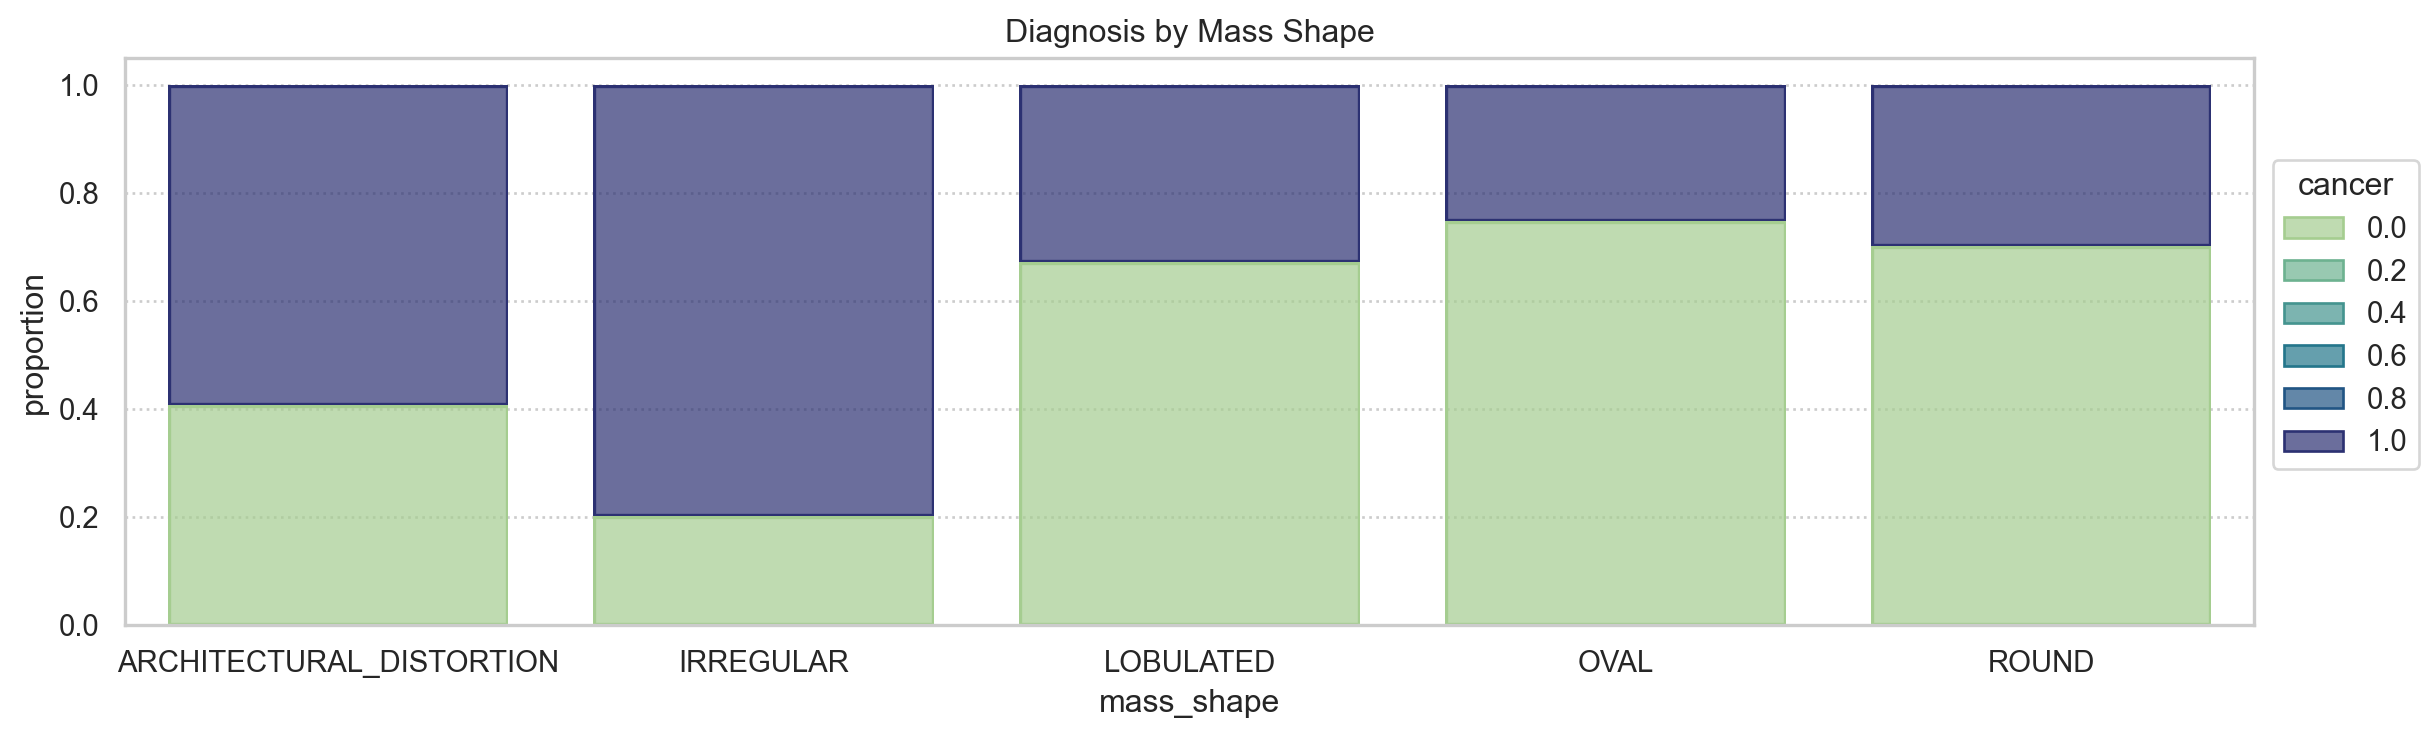

In [38]:
df_mass = mass.as_df()
df_mass['mass_shape'] = df_mass['mass_shape'].astype(str)
df_mass = df_mass.loc[df_mass['mass_shape'].isin(['IRREGULAR', 'OVAL', 'LOBULATED', 'ROUND', 'ARCHITECTURAL_DISTORTION'])].reset_index()
prop = df_mass[['mass_shape', 'cancer']].groupby(by=['mass_shape']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_shape','cancer'])
p = sns.objects.Plot(prop, x='mass_shape', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Shape").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_mass_shape", p)

```{glue:figure} eda1_bivariate_mass_shape
---
align: center
name: eda1_bivariate_mass_shape_fig
---
Diagnosis by Mass Shape
```

Irregular, and architectural distortion masses tend to indicate malignancy. Lobulated, oval and round masses appear to suggest intermediate concern of malignancy.

In [39]:
cv = mass.stats.cramersv(a='mass_shape', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5113326743578923
                          Pvalue | 3.874925805827614e-82
                           Alpha | 0.05
                        Strength | Large
                               A | mass_shape
                               B | cancer
                               N | 1696
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 443.43803215672636
                           X2dof | 19




This chi-square test of independence between mass shape and diagnosis indicates a large and significant association ($X^2$(1,n=1694)=440.92 p<0.01, $V$=0.51).

#### Mass Margins and Cancer

Mass margins, a feature that separates the mass from the adjacent breast parenchyma, is often the feature which enables differentiation between benign and malignant.

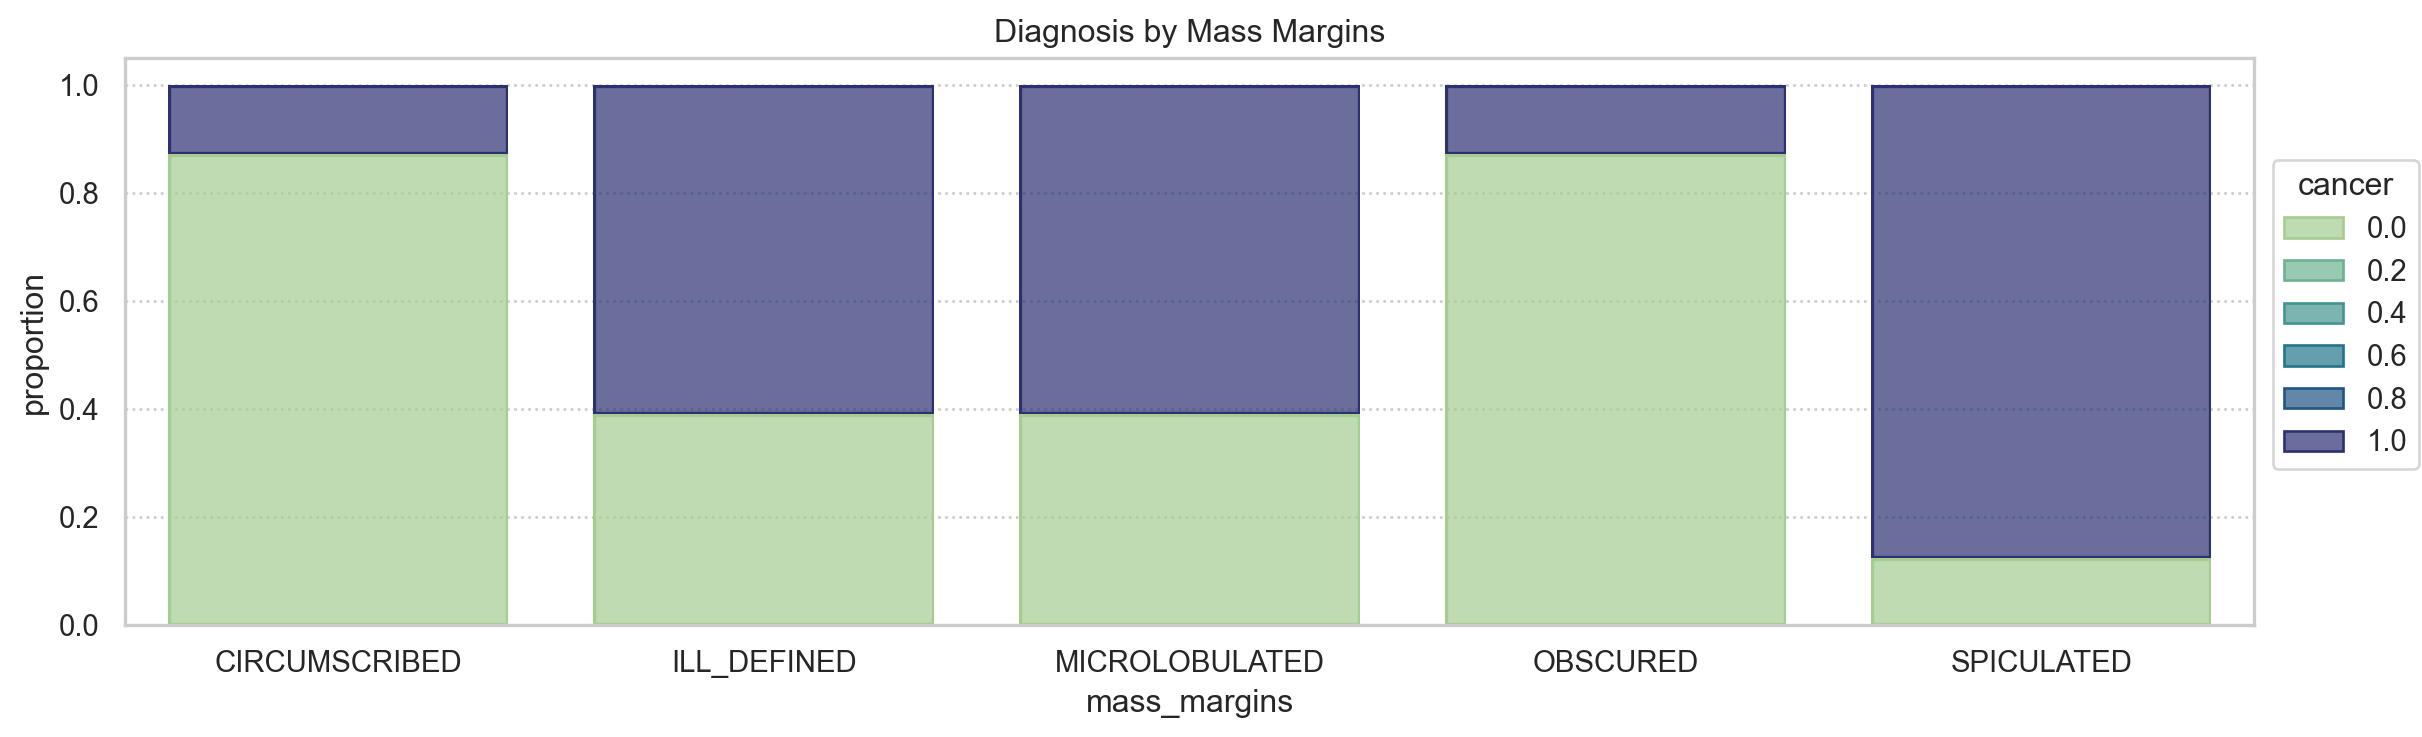

In [40]:
df_mass['mass_margins'] = df_mass['mass_margins'].astype(str)
df_mass = df_mass.loc[df_mass['mass_margins'].isin(['SPICULATED', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'OBSCURED', 'MICROLOBULATED'])].reset_index()
prop = df_mass[['mass_margins', 'cancer']].groupby(by=['mass_margins']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_margins','cancer'])
p = sns.objects.Plot(prop, x='mass_margins', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Margins").layout(size=(12,4), engine='tight').scale(color='crest')
glue("eda1_bivariate_mass_margins", p)

```{glue:figure} eda1_bivariate_mass_margins
---
align: center
name: eda1_bivariate_mass_margins_fig
---
Diagnosis by Mass Shape
```

As shown in {numref}`eda1_bivariate_mass_margins_fig`, spiculated, ill-defined, and microlobulated masses are associated with malignancy in the CBIS-DDSM. Circumscribed and obscured masses appear to indicate non-cancer.

Let's check the effect size of mass margins on diagnosis.

In [41]:
cv = mass.stats.cramersv(a='mass_margins', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.6344163619909218
                          Pvalue | 2.7692464461833718e-133
                           Alpha | 0.05
                        Strength | Large
                               A | mass_margins
                               B | cancer
                               N | 1696
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 682.6130681336065
                           X2dof | 18




This chi-square test of independence between mass margins and diagnosis indicates a large and significant association ($X^2$(1,n=1694)=588.62 p<0.01, $V$=0.59).

That concludes the target association section of the bivariate analysis. Let's examine the relationships among the features.

### Case Bivariate Feature Association Analysis
What does calcification type imply about calcification distribution? To what degree is mass shape and mass margin related? Are certain morphologies more or less subtle? In this section, we examine the strength of associations among the features in the CBIS-DDSM using Cramer's V effect size measurement. For this exercise, we'll interpret the Cramer's V effect sizes as follows:

|      V      |   Effect   |
|:-----------:|:----------:|
|    ≥ 0.5    |    Large   |
| ≥ 0.3 < 0.5 |  Moderate  |
| ≥ 0.1 < 0.3 |    Small   |
|   0 < 0.1   | Negligible |

We'll start with the full dataset to investigate the relationships between non-morphological features. Then, we'll analyze mass and calcification cases separately to avoid in spurious associations across abnormality types.

<Axes: title={'center': "CBIS-DDSM Case Feature Association Plot\nCramer's V"}>

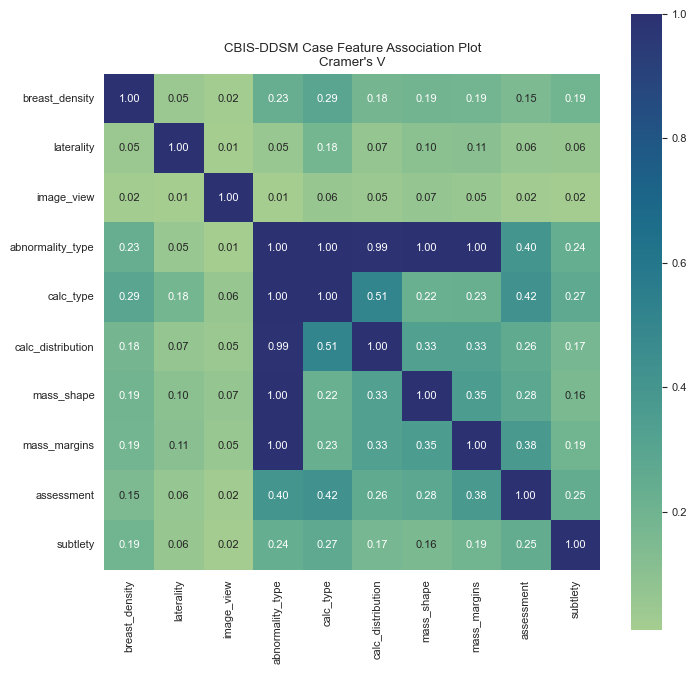

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
ax = cases.plot_feature_associations(ax=ax)
glue("eda1_bivariate_feature_association", ax)

```{glue:figure} eda1_bivariate_feature_association
---
align: center
name: eda1_bivariate_feature_association_fig
---
CBIS-DDSM Case Feature Association Plot
```

The moderate to strong associations of note are:

- Abnormality type and BI-RADS assessment (V=0.40)
- Calcification type and calcification distribution (V=0.54)
- Calcification type and BI-RADS assessment (V=0.42)
- Calcification distribution and BI-RADS assessment  (V=0.34)
- Mass shape and mass margins (V=0.35)
- Mass margins and BI-RADS assessment (V=0.37)

{numref}`eda1_bivariate_feature_association_fig` also illuminates several weak associations worthy of note:
- Breast density is weakly associated with BI-RADS assessment.
- Breast density doesn't appear to be a predictor of abnormality type
- Breast density and subtlety appear to be uncorrelated.
- Masses don't appear to be any more or less subtle than calcifications.

Let's take a closer look at the moderate to strong relationships in the CBIS-DDSM.

#### BI-RADS Assessment and Abnormality Type

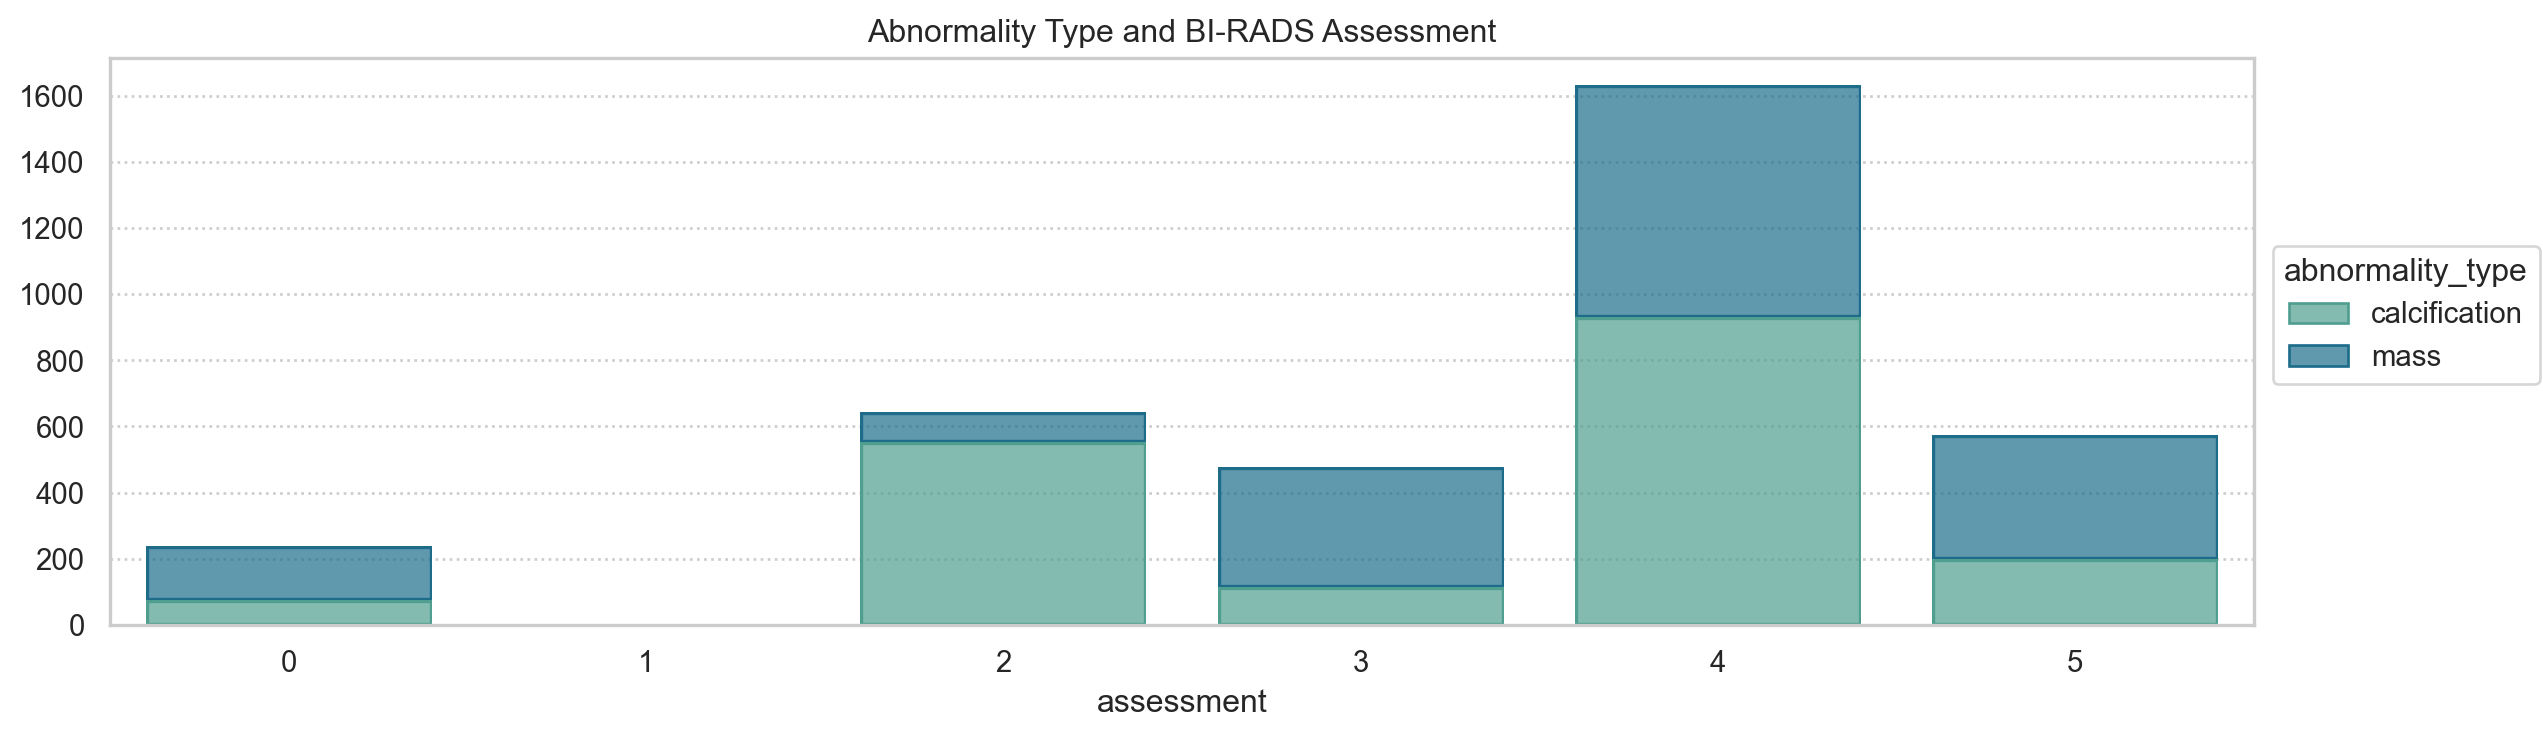

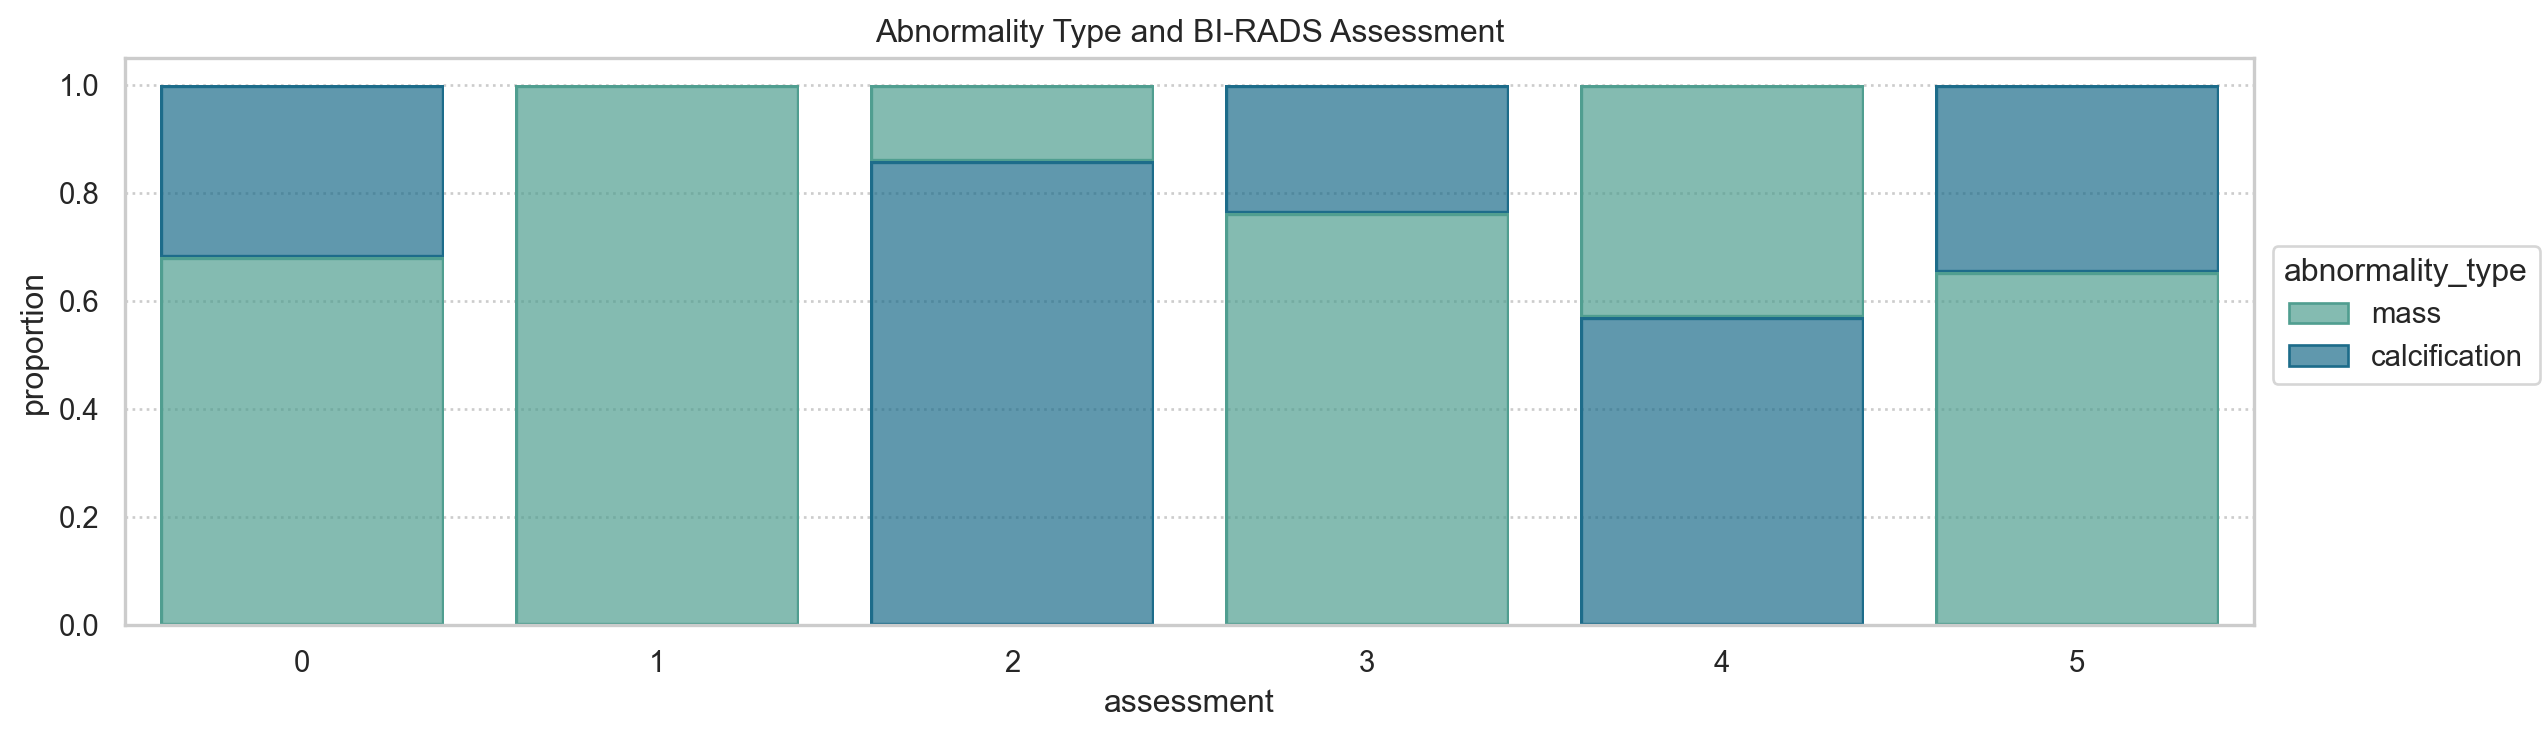

In [43]:
p1 = sns.objects.Plot(df, x='assessment', color='abnormality_type').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Abnormality Type and BI-RADS Assessment").layout(size=(12,4), engine='tight').scale(color='crest')

prop = df[['assessment', 'abnormality_type']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().reset_index().sort_values(by='assessment')
p2 = sns.objects.Plot(prop, x='assessment', y='proportion', color='abnormality_type').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Abnormality Type and BI-RADS Assessment").layout(size=(12,4), engine='tight').scale(color='crest')

glue("eda1_bivariate_abtype_assessment_count", p1)
glue("eda1_bivariate_abtype_assessment_prop", p2)

```{glue:figure} eda1_bivariate_abtype_assessment_count
---
align: center
name: eda1_bivariate_abtype_assessment_count_fig
---
Abnormality Type and BI-RADS Assessment (Counts)
```

```{glue:figure} eda1_bivariate_abtype_assessment_prop
---
align: center
name: eda1_bivariate_abtype_assessment_prop_fig
---
Abnormality Type and BI-RADS Assessment (Proportion)
```

{numref}`eda1_bivariate_abtype_assessment_count_fig` and {numref}`eda1_bivariate_abtype_assessment_prop_fig`  illuminate the relationship between abnormality type and BI-RADS assessment. Since we have less than five BI-RADS 1 (b) assessments, we'll ignore those for now. Masses appear to have a majority the  BI-RADS 0, 3, and 5 assessments; whereas, calcification cases are most prevalent in BI-RADS 2 and 4 assessments. However, the effect is moderate and so this may be an aspect specific to the CBIS-DDSM dataset.

#### Calcification Type and Calcification Distribution
Which calcification types and distributions co-occur most frequently?

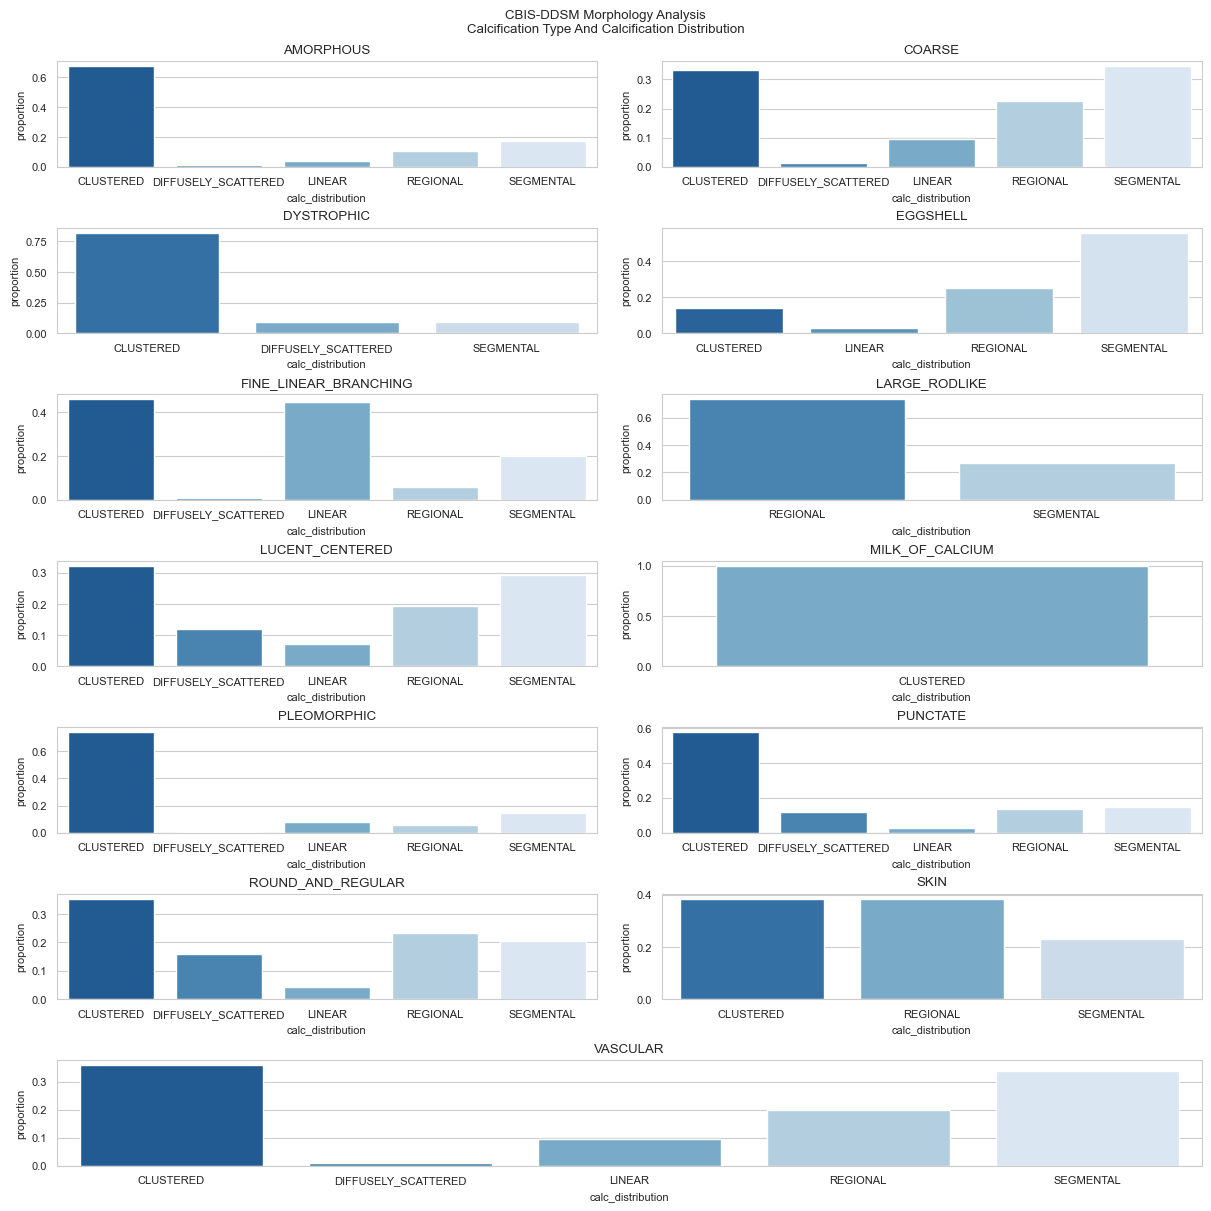

In [44]:
fig, _ = cases.compare_morphology(m1='calc_type', m2='calc_distribution', figsize=(12,12))
glue("eda1_bivariate_calc_type_dist", fig)

```{glue:figure} eda1_bivariate_calc_type_dist
---
align: center
name: eda1_bivariate_calc_type_dist_fig
---
Calcification Type and Distribution
```

{numref}`eda1_bivariate_calc_type_dist_fig` illuminates the calcification types and distributions that co-occur with greater than 50% probability.

Segmental distributions tended to co-occur with a range of calcification types, including Coarse, Eggshell, Lucent-Centered, Round and Regular, Skin, and Vascular calcification types. Clustered distributions tended to present with Amorphous, Dystrophic, Milk of Calcium, Pleomorphic, and Punctate calcification types. Finally, Regional / Large Rodlike calcifications presented together in the CBIS-DDSM.

#### Calcification Type and Assessment

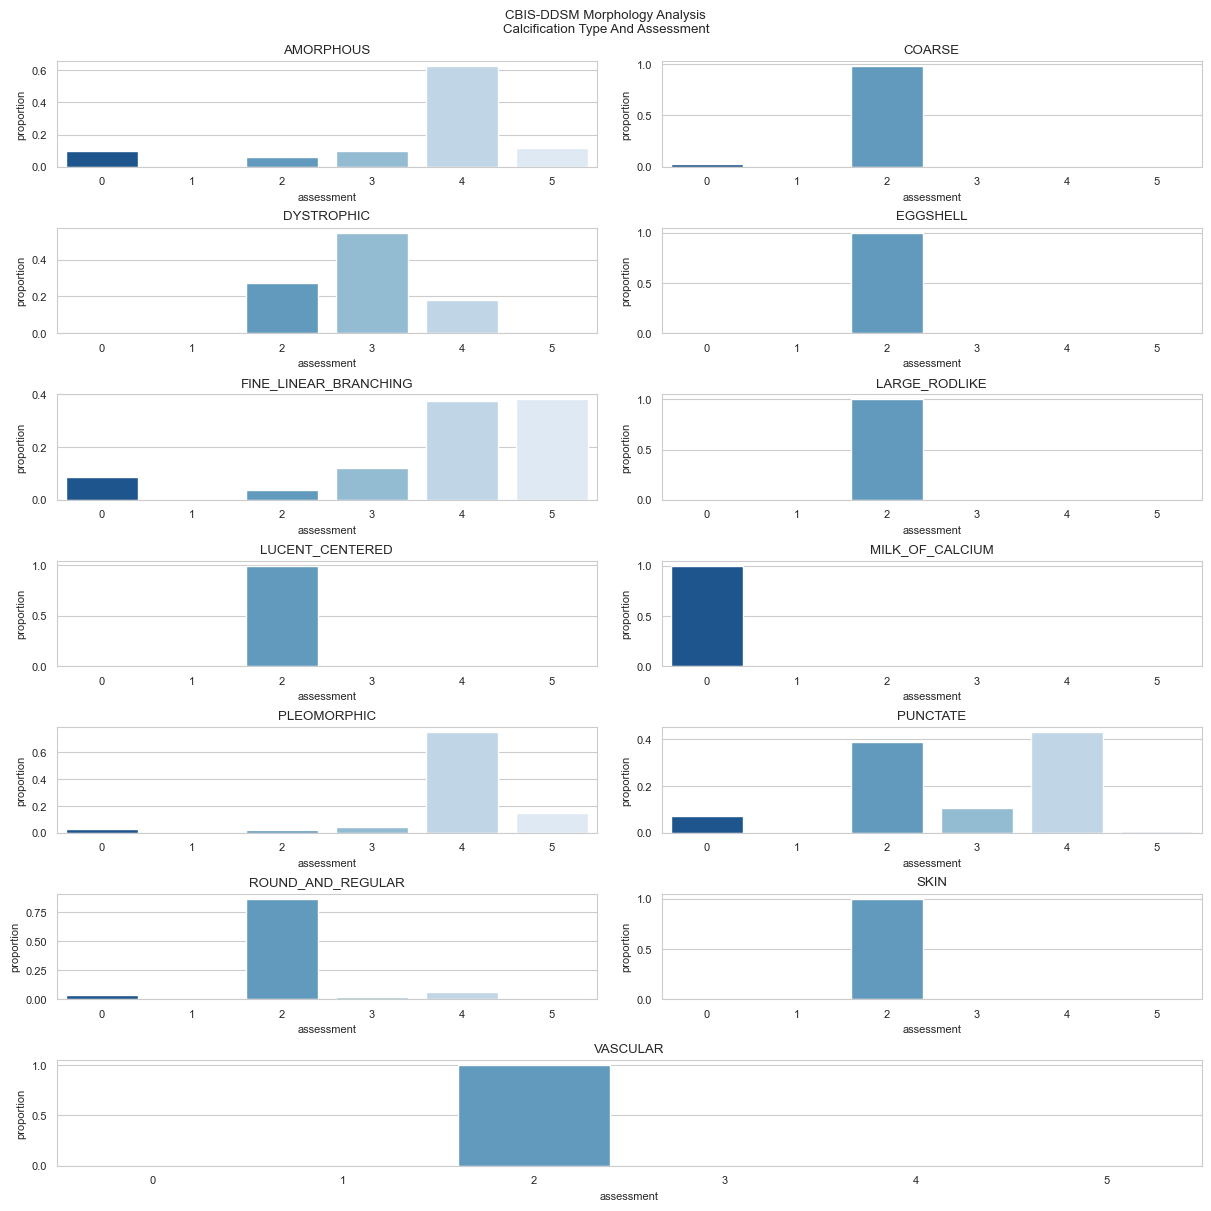

In [45]:
fig, _ = cases.summarize_morphology_by_feature(morphology='calc_type', by='assessment', figsize=(12,12))
glue("eda1_bivariate_calc_type_assessment", fig)

```{glue:figure} eda1_bivariate_calc_type_assessment
---
align: center
name: eda1_bivariate_calc_type_assessment_fig
---
Calcification Type and BI-RADS Assessment
```

In {numref}`eda1_bivariate_calc_type_assessment_fig`, we show the proportion of BI-RADS assessments for each calcification type. Pleomorphic, fine linear branching and amorphous calcifications appear to render the highest levels of suspicion with BI-RADS 4 and 5 assessments. Those of intermediate concern are dystrophic and punctate. The remaining are associated with generally benign classifications.

#### Calcification Distribution and Assessment

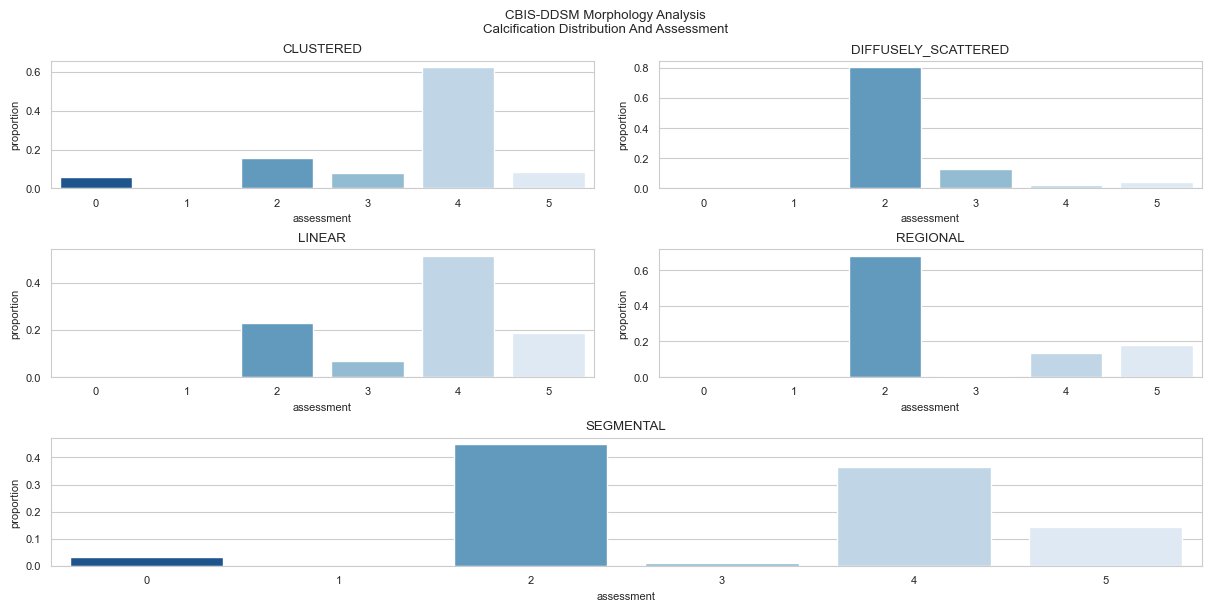

In [46]:
fig, _ = cases.summarize_morphology_by_feature(morphology='calc_distribution', by='assessment', figsize=(12,6))
glue("eda1_bivariate_calc_dist_assessment", fig)

```{glue:figure} eda1_bivariate_calc_dist_assessment
---
align: center
name: eda1_bivariate_calc_dist_assessment_fig
---
Calcification Distribution and BI-RADS Assessment
```

{numref}`eda1_bivariate_calc_dist_assessment_fig` displays the proportional relationships between calcification distribution and BI-RADS assessment.

Segmental and diffusely scattered calcifications presented with BI-RADS 2 - Benign and clustered and linear calcifications were assessed as suspicious (BI-RADS 4) with greater than 60% probablity. Regional calcifications had assessments ranging from benign to highly suspicous of malignancy.

#### Mass Shape and Mass Margins
What is the relationship between mass shape and margins in the CBIS-DDSM dataset?

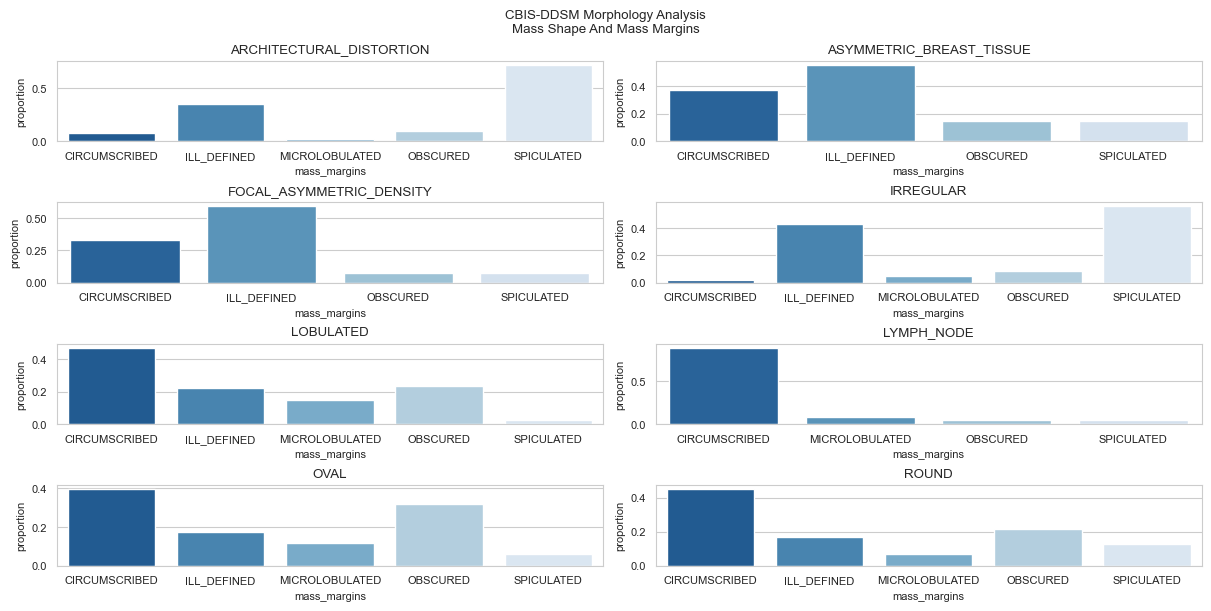

In [47]:
fig, _ = cases.compare_morphology(m1='mass_shape', m2='mass_margins', figsize=(12,6))
glue("eda1_bivariate_mass_shape_margins", fig)

```{glue:figure} eda1_bivariate_mass_shape_margins
---
align: center
name: eda1_bivariate_mass_shape_margins_fig
---
Mass Shape and Mass Margins
```

{numref}`eda1_bivariate_mass_shape_margins_fig` presents the relationships between the mass shapes and margins in the CBIS-DDSM dataset. Architectural distortion and spiculated masses co-occurred with greater than 50% probability. Asymmetric breast tissue and focal asymmetric density presented most frequently with ill-defined and spiculated masses. Irregular masses co-occurred with spiculated masses with greater than 50% probability. Finally, lobulated, lymph node, oval, and round masses co-occurred most frequently with circumscribed mass margins.

### Summary CBIS-DDSM Case Bivariate Analysis
This concludes the bivariate component of this exploratory data analysis. Let's summarize our observations thus far.

Our bivariate analysis was conducted in two parts:
1. Bivariate Target Variable Association Analysis
2. Bivariate Feature Association Analysis

The former examined the relationships between the features and the target variable, 'cancer' and the latter explored the relationships between feature pairs.

<Axes: title={'center': "CBIS-DDSM Target Association Plot\nCramer's V"}, xlabel='strength', ylabel='variable'>

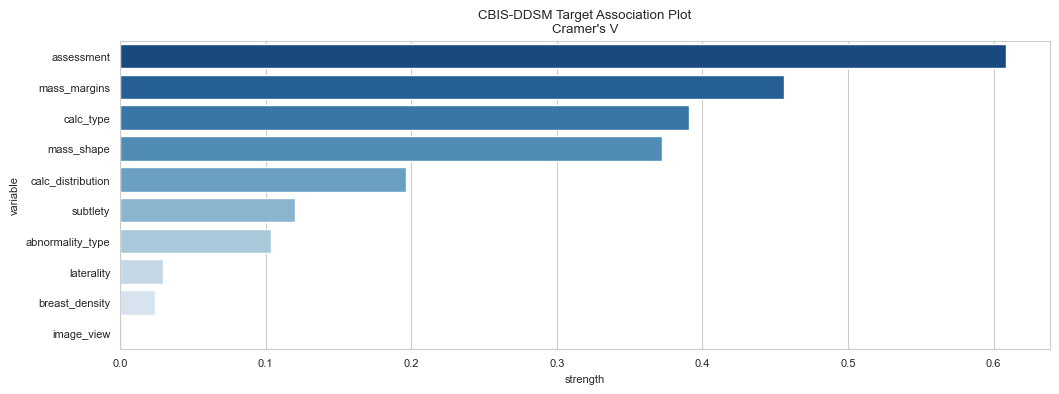

In [48]:
ax = cases.plot_target_associations()
glue("eda1_bivariate_target_associations", ax)

```{glue:figure} eda1_bivariate_target_associations
---
align: center
name: eda1_bivariate_target_associations_fig
---
Mass Shape and Mass Margins
```

#### Bivariate Target Association Analysis Summary

{numref}`eda1_bivariate_target_associations_fig` depicts the Cramer's V associations between the independent variables and our target variable, 'cancer'. The main observations are as follows:

1. There was strong agreement between the BI-RADS assessments and the pathology ($\tau$=0.60, p<0.01); an expected finding as many of the BI-RADS assessments were likely updated as additional information was gathered by the physician {cite}`leeCuratedMammographyData2017`.
2. Of the morphological features, mass margins had the strongest association with the diagnostic outcome. ($X^2$(1,n=1694)=588.62 p<0.01, $V$=0.59). The margins most associated with malignancy were ill-defined, microlobulated, and spiculated.
3. Calcification type was also strongly associated with pathology ($X^2$(1,n=1872)=539.69 p<0.01, $V$=0.54). Pleomorphic and fine linear branching were most highly associated with malignancy.
4. Mass shape had a large and significant effect on pathology in the dataset ($X^2$(1,n=1694)=440.92 p<0.01, $V$=0.51). Lobulated, round, and oval masses had malignancy rates exceeding 60% in the CBIS-DDSM dataset.
5. Calcification distribution had a moderate effect on pathology.  ($X^2$(1,n=1872)=198.56 p<0.01, $V$=0.33). Linear calcifications had the greatest rate of malignancy, followed by regional, clustered calcifications. Segmental and diffusely scattered calcifications were more indicative of a benign pathology.
6. Subtlety, abnormality type, breast, breast density, and image image_view were all weakly associated with pathology.

#### Bivariate Feature Association Analysis Summary
Cramer's V was used to measure the degree of association between the features. We observed several strong associations in both calcification and mass cases:
1. Calcification Cases:
   1. There was a strong association (V=0.54) between calcification type and BI-RADS assessment.
   2. Moderate associations were observed between:
      1. breast density and calcification type
      2. calcification type and distribution
      3. calcification type and subtlety
      4. calcification distribution and BI-RADS assessment
   3. The other features were weakly associated.
2. Mass Cases:
   1. No strong associations were observed among the features in the mass dataset.
   2. Moderate associations were observed between:
      1. mass shape and BI-RADS assessment
      2. mass margins and BI-RADS assessment
   3. Other features were weakly associated.

Next, multivariate data analysis.

## Multivariate Analysis

The purpose of the multivariate analysis is to elucidate features of the data, beyond that which can be derived from the univariate, and bivariate analyses above. Our objectives; therefore, are to:

1. Examine the relationships among the morphological features and the diagnosis.
2. Estimate the importance of each independent variable in explaining the diagnosis.
3. Establish a model to predict a diagnosis, given the independent variables.

We begin with the morphological feature analysis.

### Morphological Analysis

The morphology, the form and structure of the abnormality, is the most important factor in the differentiation between a benign and malignant diagnosis. Here, we explore the relationship between the morphological factors and the diagnostic outcome. Concretely, we ask which combinations of morphologies are most malignant.

We’ll start with mass shape and margins.

#### Probability of Malignancy by Mass Shape and Margin

<Axes: title={'center': 'Probability of Malignancy by Mass Shape and Mass Margins.'}, xlabel='mass_margins', ylabel='mass_shape'>

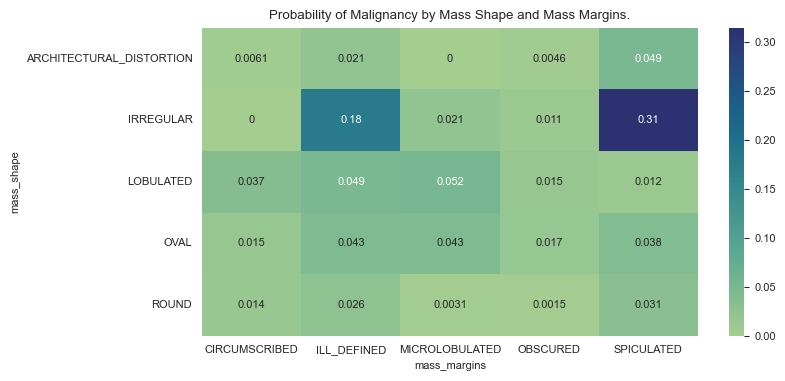

In [49]:
ax = cases.morphology_analysis(a='mass_shape', b='mass_margins')
glue("eda1_multivariate_mass_analysis", ax)

```{glue:figure} eda1_multivariate_mass_analysis
---
align: center
name: eda1_multivariate_mass_analysis_fig
---
Probability of Malignancy by Mass Shape and Margin
```

{numref}`eda1_multivariate_mass_analysis_fig` shows a heat map of probabilities of malignancy by mass shape and margin.

Note: this analysis was restricted to the five most frequently occurring mass shapes and margins which account for ~87% and ~93% of the cases respectively.

The values in the heat map are the sum of the boolean cancer variable for each mass shape/mass margin combination, normalized by the total number of observations in the subset.

Irregular masses have a ~48% chance of malignancy as indicated by our data. Of the irregular masses, those with a spiculated and ill-defined margin have a probability of malignancy of ~31% and ~17% respectively.

#### Probability of Malignancy by Calcification Type and Distribution

<Axes: title={'center': 'Probability of Malignancy by Calcification Type and Calcification Distribution.'}, xlabel='calc_distribution', ylabel='calc_type'>

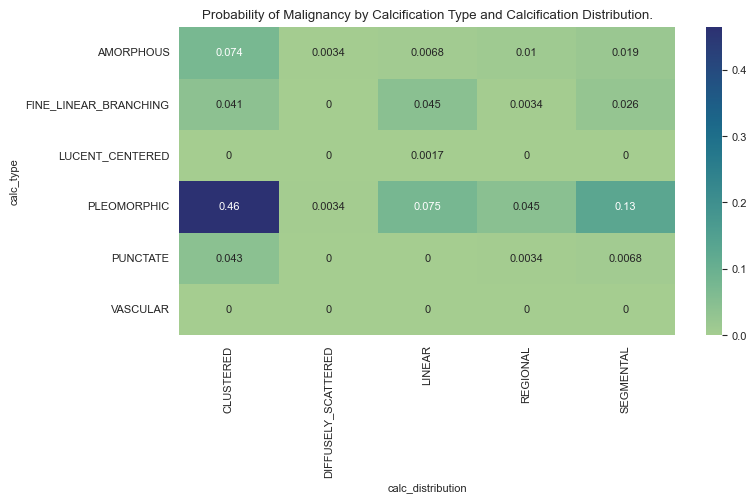

In [50]:
ax = cases.morphology_analysis(a='calc_type', b='calc_distribution')
glue("eda1_multivariate_calc_analysis", ax)

```{glue:figure} eda1_multivariate_calc_analysis
---
align: center
name: eda1_multivariate_calc_analysis_fig
---
Probability of Malignancy by Calcification Type and Distribution
```

{numref}`eda1_multivariate_mass_analysis_fig` shows a heat map of probabilities of malignancy by calcification type and distribution.

Again, we've restricted the analysis to the most frequently occurring calcification types and distributions which represent ~80% and ~97% of the cases respectively.

Pleomorphic calcifications account for ~60% of the malignancies in the CBIS-DDSM dataset. Of those, clustered and segmental distributions represent malignancies at probabilities of ~47% and ~13% respectively.

### Model Selection

 Logistic Regression, Support Vector Machines, Random Forests, and Gradient Boosting classifiers will be trained on the calcification and mass training data separately. The models will be evaluated on unseen test data and we will extract feature importances from the algorithm with the greatest positive class recall. Given the high cost of a false negative, we will use recall as the metric by which model performance will be evaluated.

In [51]:
FORCE_MODEL_FIT = False

#### Build Pipelines
Pipelines are built for each classifier.

In [52]:
pb = PipelineBuilder()
pb.set_jobs(6)
pb.set_standard_scaler()
pb.set_scorer('accuracy')

# Build Logistic Regression Pipeline
params_lr = [{'clf__penalty': ['l1', 'l2'],
		      'clf__C': [1.0, 0.5, 0.1],
		      'clf__solver': ['liblinear']}]
clf = LogisticRegression(random_state=5)
pb.set_classifier(classifier=clf, params=params_lr)
pb.build_gridsearch_cv()
lr = pb.pipeline

# Build SVM Pipeline
clf = SVC(random_state=5)
params_svc = [{'clf__kernel': ['linear'],
		       'clf__C': [1,2,3,4,5, 6, 7, 8, 9, 10]}]
pb.set_classifier(classifier=clf, params=params_svc)
pb.build_gridsearch_cv()
svc = pb.pipeline

# Build Random Forest Pipeline
clf = RandomForestClassifier(random_state=5)
param_range = [1,2,3,4,5]
params_rf = [{'clf__criterion': ['gini', 'entropy'],
		      'clf__min_samples_leaf': param_range,
		      'clf__max_depth': param_range,
		      'clf__min_samples_split': param_range[1:]}]
pb.set_classifier(classifier=clf, params=params_rf)
pb.build_gridsearch_cv()
rf = pb.pipeline

# Build Gradient Boosting Pipeline
clf = GradientBoostingClassifier(random_state=5)
param_range = [1,2,3,4,5]
params_rf = [{'clf__criterion': ['friedman_mse', 'squared_error'],
		      'clf__min_samples_leaf': param_range,
		      'clf__max_depth': param_range,
		      'clf__min_samples_split': param_range[1:]}]
pb.set_classifier(classifier=clf, params=params_rf)
pb.build_gridsearch_cv()
gb = pb.pipeline

#### Calcification Case Multivariate Analysis
##### Get Model Data

In [53]:
X_train, y_train, X_test, y_test = cases.get_calc_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

##### Build and Execute Model Selection

In [54]:
BEST_CALC_MODEL_FP = os.path.abspath('model/eda/best_calc_pipeline.pkl')

In [55]:

# Build Model Selector
calc_ms = ModelSelector(filepath=BEST_CALC_MODEL_FP)
calc_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
calc_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
calc_ms.add_pipeline(pipeline=rf, name="Random Forest")
calc_ms.add_pipeline(pipeline=gb, name="Gradient Boosting")

##### Prediction Results

In [56]:
calc_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = calc_ms.predict(X=X)
calc_ms.score(y_true=y, y_pred=y_pred)

Best Model: Logistic Regression loaded from file.

		Accuracy of Logistic Regression: 0.54
			Classification Report
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1199
           1       0.66      0.54      0.60       673

    accuracy                           0.73      1872
   macro avg       0.71      0.69      0.70      1872
weighted avg       0.73      0.73      0.73      1872



The Logistic Regression and Gradient Boosting Classifiers performed equally well with respect to recall (0.53) on *unseen* calcification  data. Random Forest had the highest recall on the calcification *training* data.

##### Calcification Variable Importance

The magnitude of the model coefficients indicate the importance of the feature to the prediction task. A positive value provides evidence that the instance being classified belongs to the positive or malignant class; whereas, a negative value provides evidence that the instance being classified belongs to the negative or benign class. Let's take a look.

<Axes: title={'center': 'CBIS-DDSM Multivariate Analysis\nCalcification Cases\nFeature Importance'}, xlabel='Importance', ylabel='Feature'>

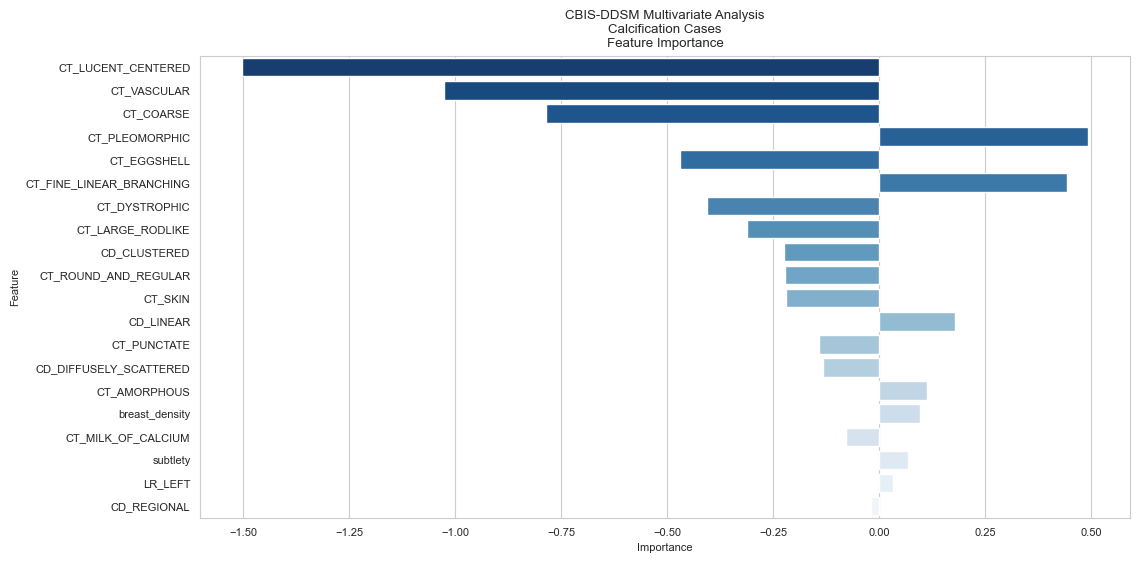

In [57]:
fig, ax = plt.subplots(figsize=(12,6))
title = f"CBIS-DDSM Multivariate Analysis\nCalcification Cases\nFeature Importance"
ax = calc_ms.plot_feature_importance(title=title, ax=ax)
glue("eda1_multivariate_calc_feature_importance", ax)

```{glue:figure} eda1_multivariate_calc_feature_importance
---
align: center
name: eda1_multivariate_calc_feature_importance_fig
---
Feature Importance for Calcification Cases in the CBIS-DDSM Dataset
```

In {numref}`eda1_multivariate_calc_feature_importance_fig`, we see that calcification types have the greatest impact on the classification task. Further, the feature weight of evidence aligns with current literature on the differential of breast calcifications. For instance, lucent-centered, vascular, and course calcifications are generally associated with a BI-RADS 2 classification, benign. Pleomorphic and fine linear branching calcifications are considered suspicious to highly suspicious.

#### Mass Case Multivariate Analysis
##### Get Model Data

In [58]:
X_train, y_train, X_test, y_test = cases.get_mass_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

##### Build and Execute Model Selection

In [59]:
BEST_MASS_MODEL_FP = os.path.abspath('model/eda/best_mass_pipeline.pkl')

In [60]:
# Build Model Selector
mass_ms = ModelSelector(filepath=BEST_MASS_MODEL_FP)
mass_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
mass_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
mass_ms.add_pipeline(pipeline=rf, name="Random Forest")
mass_ms.add_pipeline(pipeline=gb, name="Gradient Boosting")

##### Prediction Results

In [61]:
mass_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = mass_ms.predict(X=X)
mass_ms.score(y_true=y, y_pred=y_pred)

Best Model: Support Vector Classifier loaded from file.

		Accuracy of Support Vector Classifier: 0.89
			Classification Report
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       912
           1       0.72      0.89      0.80       784

    accuracy                           0.79      1696
   macro avg       0.80      0.80      0.79      1696
weighted avg       0.81      0.79      0.79      1696



The Support Vector Classifier had the highest test set recall of 0.87.

Let's examine feature importance.

##### Mass Variable Importance

<Axes: title={'center': 'CBIS-DDSM Multivariate Analysis\nMass Cases\nFeature Importance'}, xlabel='Importance', ylabel='Feature'>

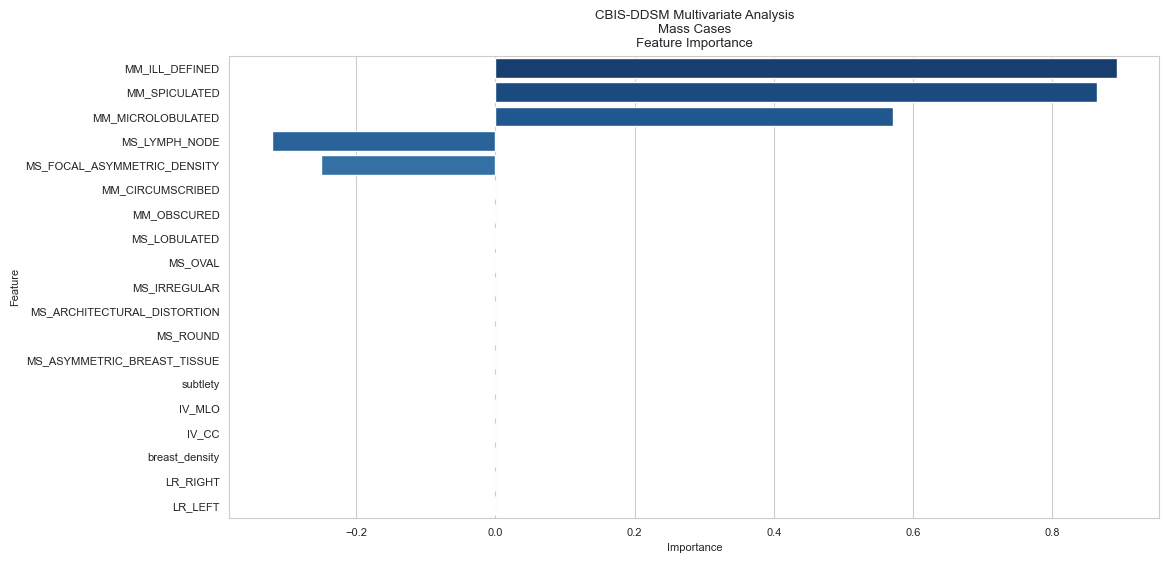

In [62]:
fig, ax = plt.subplots(figsize=(12,6))
title = f"CBIS-DDSM Multivariate Analysis\nMass Cases\nFeature Importance"
ax = mass_ms.plot_feature_importance(title=title, ax=ax)
glue("eda1_multivariate_mass_feature_importance", ax)

```{glue:figure} eda1_multivariate_mass_feature_importance
---
align: center
name: eda1_multivariate_mass_feature_importance_fig
---
Feature Importance for Mass Cases in the CBIS-DDSM Dataset
```

As shown in {numref}`eda1_multivariate_mass_feature_importance_fig`, ill-defined, spiculated, and microlobulated mass margins indicated suspicion of breast cancer. Lymph node and focal asymmetric density shapes were most closely associated with benign pathology.

This concludes the multivariate analysis portion of the exploratory data analysis part 1. Let's summarize our findings.

## Summary

Our aim for this section was to acquire insight into the CBIS-DDSM dataset and the factors that distinguish benign from malignant diagnoses in digital mammography screening. To that end, univariate, bivariate, and multivariate analyses were undertaken to understand how the data were distributed within the CBIS-DDSM dataset, to determine whether a statistical association exists between the features and between the features and the diagnosis, to evaluate how morphological features relate to a diagnosis and finally, to ascertain the relative importance of features to the classification task. Here we summarize the key findings from the analysis effort.

### Distribution of Data

1.	Approximately 60% of the cases are benign, indicating a slight class imbalance which could lead to biased predictions.
2.	For calcification cases, pleomorphic, amorphous, punctate, lucent-centered, and fine linear branching calcification types account for ~75% of the calcification case types.
3.	Approximately 85% of the calcification cases had either clustered or segmental classification distributions.
4.	For mass cases, irregular, oval, lobulated, and round masses represented ~85% of all mass cases.
5.	The five most frequently encountered mass margins: spiculated, circumscribed, ill-defined, obscured, and microlobulated, covered over 93% of the mass cases.
6.	The majority (~70%) of cases have BI-RADS b and c breast densities, the remainder is evenly split between BI-RADS a and d densities.

### Feature and Target Associations

1.	Of the morphological features, mass margins had the strongest association with the diagnostic outcome. Ill-defined, microlobulated,  and spiculated margins were associated with the highest rates of malignancy.
2.	Calcification type was also strongly associated with pathology. Pleomorphic and fine linear branching were most highly associated with malignancy.
3.	Calcification distribution had a moderate effect on classification outcome. Linear calcification distributions had the highest rate of malignancy, followed by regional, and clustered distributions. Segmental and diffusely scattered distributions tended to indicate a benign pathology.
4.	Subtlety, image view, left-or-right side, and breast density were all weakly associated with the outcome.

### Feature Importance

1.	The three most important features for mass differential diagnoses were ill-defined, spiculated, and microlobulated mass margins. Lymph node, focal asymmetrical density, and asymmetric breast tissue were three mass shapes that had a strong, but lesser degree of importance than the mass margins.
2.	For calcification cases, calcification type dominated the feature list in terms of importance. The top five included lucent-centered, punctate, amorphous, round and regular, and vascular calcification types.

This concludes part 1 of the exploratory analysis. Next, we analyze the CBIS-DDSM imaging data.